# Plotting II

In [1]:
from utils import (
    BaseForecaster, 
    ResidualForecaster,
    TimeSeriesPreprocessor,
    crps,
    HistoricalForecaster
)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
from darts import TimeSeries
import numpy as np
import CRPS.CRPS as forecastscore
from darts.metrics import rmse
import matplotlib as mpl

targets = pd.read_csv("targets.csv.gz")

In [58]:
targets = pd.read_csv("targets.csv.gz")

# For the training set
data_preprocessor = TimeSeriesPreprocessor(
    validation_split_date='2022-07-19',
    load_dir_name='preprocessed_train/',
)

_ = [data_preprocessor.preprocess_data(site) for site in ['BARC']]

data_preprocessor.save()

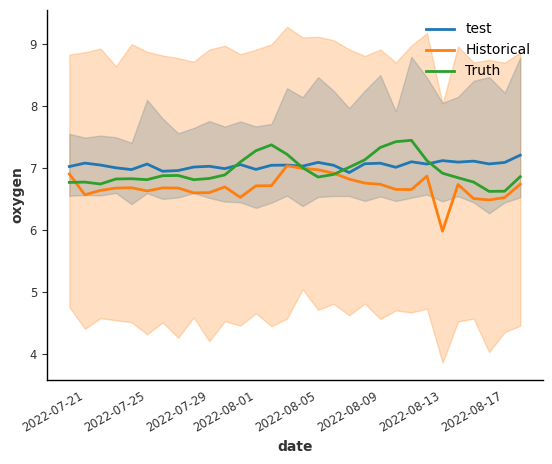

In [5]:
plot_forecasts(['test'], '2022_07_20', targets, 'FLNT', 'oxygen')

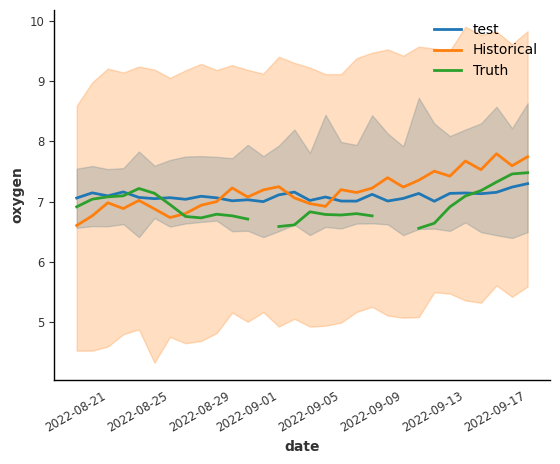

In [6]:
plot_forecasts(['test'], '2022_08_19', targets, 'FLNT', 'oxygen')

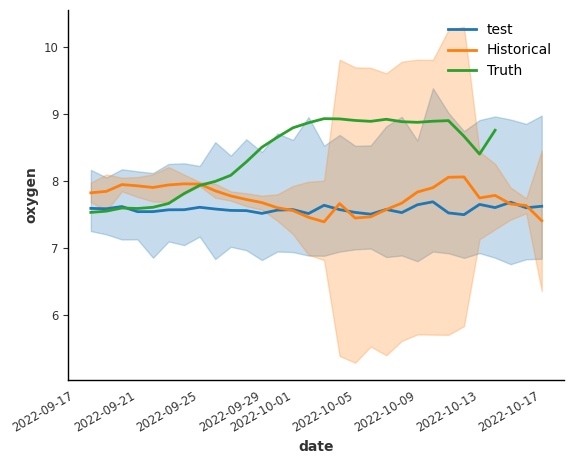

In [7]:
plot_forecasts(['test'], '2022_09_18', targets, 'FLNT', 'oxygen')

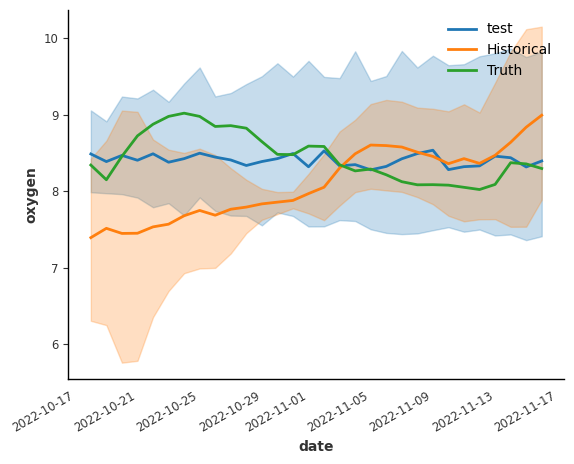

In [8]:
plot_forecasts(['test'], '2022_10_18', targets, 'FLNT', 'oxygen')

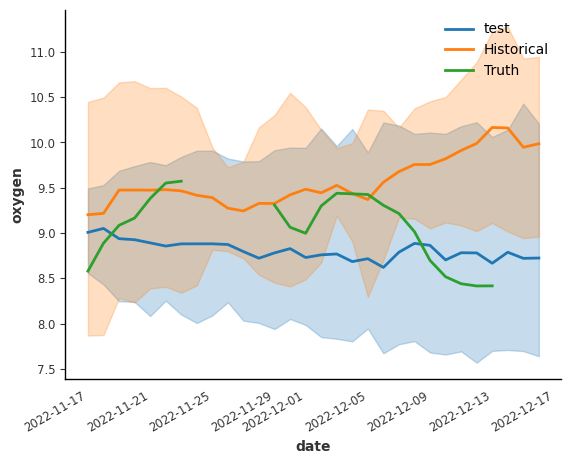

In [9]:
plot_forecasts(['test'], '2022_11_17', targets, 'FLNT', 'oxygen')

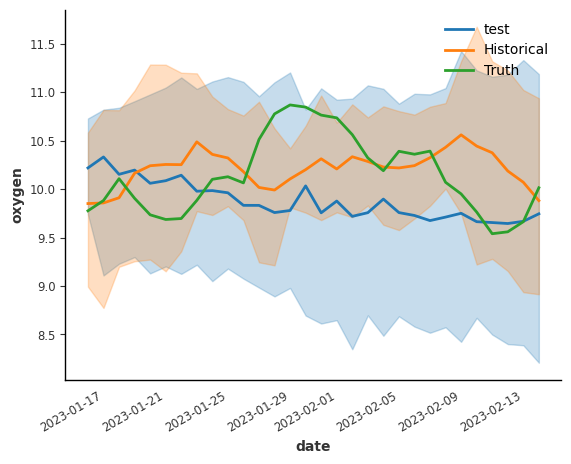

In [12]:
plot_forecasts(['test'], '2023_01_16', targets, 'FLNT', 'oxygen')

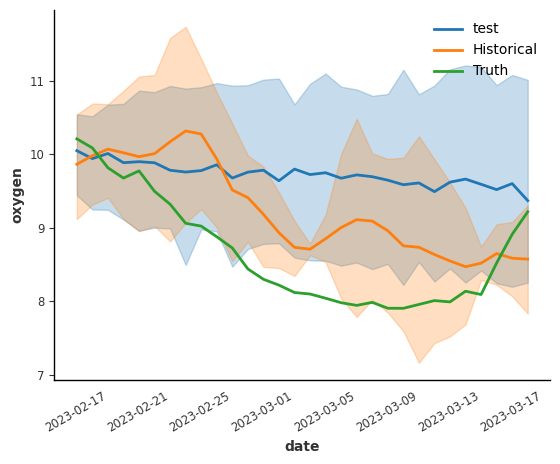

In [13]:
plot_forecasts(['test'], '2023_02_15', targets, 'FLNT', 'oxygen')

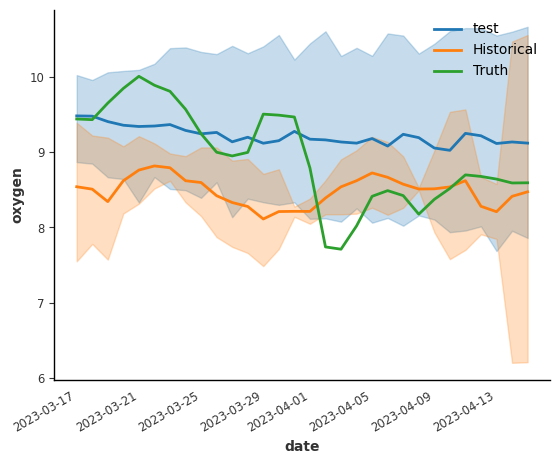

In [14]:
plot_forecasts(['test'], '2023_03_17', targets, 'FLNT', 'oxygen')

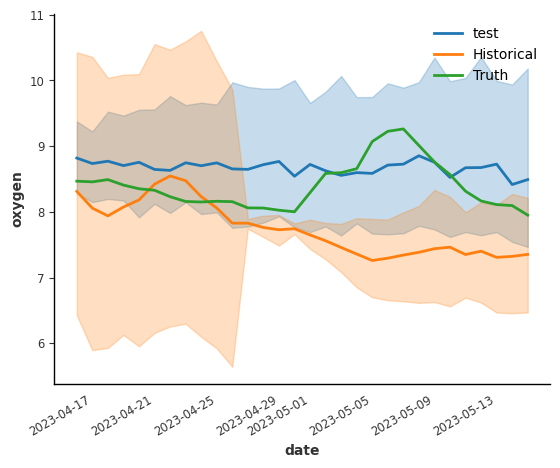

In [15]:
plot_forecasts(['test'], '2023_04_16', targets, 'FLNT', 'oxygen')

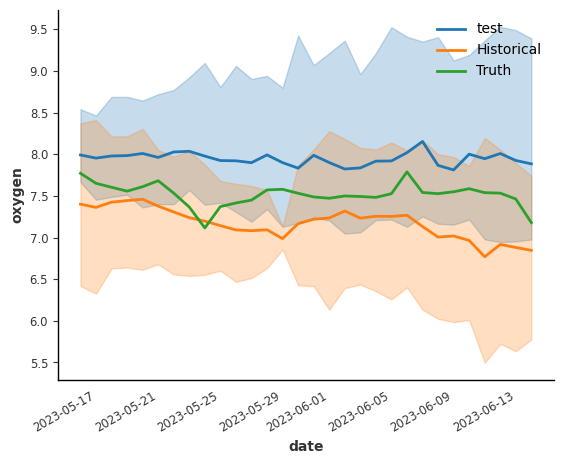

In [16]:
plot_forecasts(['test'], '2023_05_16', targets, 'FLNT', 'oxygen')

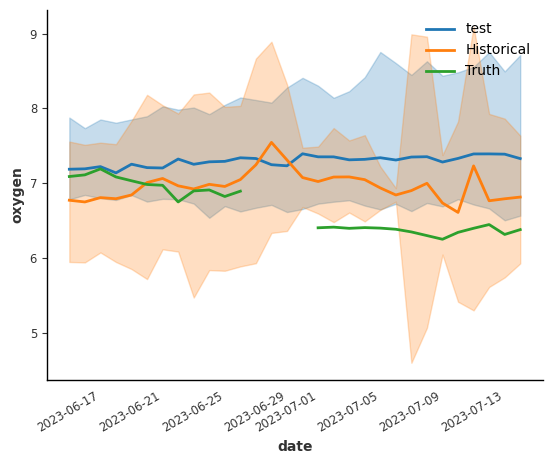

In [18]:
plot_forecasts(['forecasts/ARIK/oxygen/BlockRNNtest'], '2023_06_15', targets, 'FLNT', 'oxygen')

In [25]:
from darts import TimeSeries
from typing import Optional
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from darts.models import GaussianProcessFilter
from darts import TimeSeries
from sklearn.gaussian_process.kernels import RBF
from darts.models import (
                          BlockRNNModel, 
                          TCNModel, 
                          RNNModel, 
                          TransformerModel, 
                          NLinearModel,
                          DLinearModel,
                          NBEATSModel,
                          XGBModel,
                          LinearRegressionModel,
                          TFTModel,
                         )
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from datetime import datetime, timedelta
import ray
import CRPS.CRPS as forecastscore
import os
import optuna
import pdb
import argparse
import copy
import numpy as np
from torchmetrics import SymmetricMeanAbsolutePercentageError
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import warnings

class HistoricalForecaster():
    def __init__(self,
                 targets: Optional = None,
                 site_id: Optional[str] = None,
                 target_variable: Optional[str] = "oxygen",
                 output_csv_name: Optional[str] = "historical_forecaster_output.csv",
                 validation_split_date: Optional[str] = "2023-03-09", #YYYY-MM-DD
                 forecast_horizon: Optional[int] = 30,
                 datetime_column_name: Optional[str] = "datetime",
                 ):
        self.targets = targets
        # Changing the date from a string to a datetime64 object
        self.targets['datetime'] = pd.to_datetime(self.targets.datetime)
        self.target_variable = target_variable
        self.output_csv_name = output_csv_name
        self.validation_split_date = validation_split_date
        self.forecast_horizon = forecast_horizon
        self.datetime_column_name = datetime_column_name
        self.site_id = site_id
        self._preprocess_data()

    def _preprocess_data(self):
        # Doing some basic filtering and tidying
        site_df = self.targets.loc[self.targets.site_id == self.site_id]
        tidy_df = pd.melt(site_df, 
                          id_vars=['datetime', 'site_id'], 
                          var_name='variable', 
                          value_name='observation')
        variable_df = tidy_df.loc[tidy_df.variable == self.target_variable]
        # Cutting off before the validation split date
        split_date = pd.to_datetime(self.validation_split_date)
        self.year = split_date.year
        variable_df = variable_df[variable_df["datetime"] < split_date]
        # Now finding the mean and std according to day of the year
        variable_df["day_of_year"] = variable_df["datetime"].dt.dayofyear
        self.doy_df = variable_df.groupby(['day_of_year'])['observation'].agg(['mean', 'std'])
        global_mean = variable_df["observation"].mean()
        global_std = variable_df["observation"].std()
        # Confirm that there are 365 days, if there aren't fill in with na
        for doy in range(1, 366):
            try:
                self.doy_df.loc[doy]
            except:
                self.doy_df.loc[doy] = [np.nan, np.nan]
        # If there are persistent gaps in the data, fill in with global mean and std
        for index, row in self.doy_df.iterrows():
            if np.isnan(row["mean"]):
                self.doy_df.loc[index]["mean"] = global_mean
            if np.isnan(row["std"]):
                self.doy_df.loc[index]["std"] = global_std
    

    def make_forecasts(self):
        """
        This function finds the historical mean and var, and uses these statistics for
        the forecast
        """
        # Getting the doys for the forecast window
        forecast_doys = pd.date_range(
            start=self.validation_split_date, 
            periods=self.forecast_horizon, 
            freq='D',
        ).dayofyear
        forecast_df = self.doy_df.loc[forecast_doys]


        # Drawing samples from a gaussian centered at historical mean and std
        samples = np.array([np.random.normal(self.doy_df.loc[self.doy_df.index == doy]["mean"],
                                    self.doy_df.loc[self.doy_df.index == doy]["std"],
                                    size=(1, 500)) for doy in forecast_df.index])

        # Function to give date from the numerical doy
        def day_of_year_to_date(year, day_of_year):
            base_date = datetime(year, 1, 1)
            target_date = base_date + timedelta(days=day_of_year - 1)
            return target_date
            
        # Catching case where there is no sensor data at all for that site
        if not np.isnan(samples.mean()):
            # Now creating an index going from doy to date, being careful of year
            date_index = []
            index_year = self.year
            for day in forecast_df.index:
                date_index.append(day_of_year_to_date(index_year, day))
                if day == 365:
                    index_year += 1
                    
            forecast_df.index = date_index
    
            # Putting together the forecast timeseries
            self.forecast_df = forecast_df
            # fix dates here
            self.forecast_ts = TimeSeries.from_times_and_values(
                forecast_df.index, 
                samples,
                fill_missing_dates=True,
                freq='D'
            )
            
        else:
            self.forecast_df = None
            self.forecast_ts = None


    def get_residuals(self):
        # This needs to be re-examined!!!
        residual_list = []
        # Finding the difference between the doy historical mean and
        # the observed value
        for date in self.training_set.time_index:
            doy = date.dayofyear
            observed = self.training_set.slice_n_points_after(date, 
                                                              1).median().values()[0][0]
            historical_mean = self.doy_df.loc[doy]["mean"]
            residual = observed - historical_mean
            residual_list.append(residual)

        self.residuals = TimeSeries.from_times_and_values(self.training_set.time_index, 
                                                          residual_list)

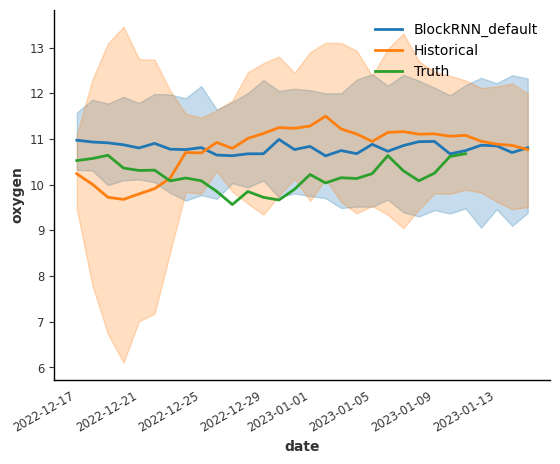

In [8]:
plot_forecast('2022_12_17', targets, 'BIGC', 'oxygen', 'BlockRNN_default')

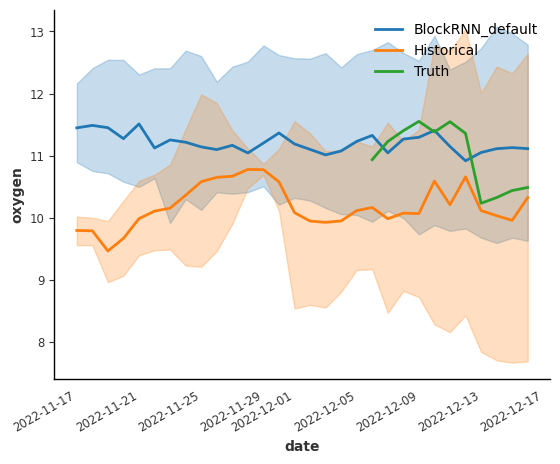

In [20]:
plot_forecast('2022_11_17', targets, 'BIGC', 'oxygen', 'BlockRNN_default')

In [ ]:
['2022_07_20', '2022_08_19', '2022_09_18', '2022_10_18', '2022_11_17', '2022_12_17', '2023_01_16', '2023_02_15', '2023_03_17', '2023_04_16', '2023_05_16', '2023_06_15']

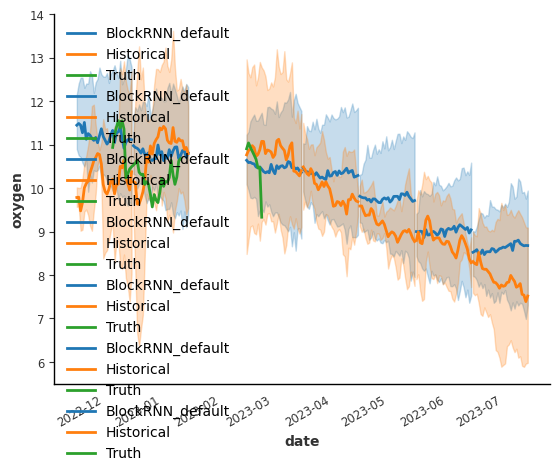

In [9]:
for date in ['2022_11_17', '2022_12_17', '2023_02_15', '2023_03_17', '2023_04_16', '2023_05_16', '2023_06_15']:
    plot_forecast(date, targets, 'BIGC', 'oxygen', 'BlockRNN_default')

In [2]:
def plot_forecast(date, targets_df, site_id, target_variable, model_dir, plot_name=None):
    cmap = mpl.colormaps["tab10"]
    colors = cmap.colors
    # Loading the forecast csv and creating a time series
    csv_name = f"forecasts/{site_id}/{target_variable}/{model_dir}/forecast_{date}.csv"
    df = pd.read_csv(csv_name)
    times = pd.to_datetime(df["datetime"])
    times = pd.DatetimeIndex(times)
    values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((len(times), 1, -1))
    model_forecast = TimeSeries.from_times_and_values(times, 
                                                      values, 
                                                      fill_missing_dates=True, freq="D")
    model_forecast.plot(label=f"{model_dir}", color=colors[0])

    # Getting the validation series directly from the targets csv
    date = model_forecast.time_index[0]
    forecast_horizon = len(model_forecast)
    validation_series = get_validation_series(
        targets_df, 
        site_id, 
        target_variable, 
        date, 
        forecast_horizon
    )

    # Now, making the forecast based off of historical mean and std
    historical_model = HistoricalForecaster(
        targets=targets_df,
        site_id=site_id,
        target_variable=target_variable,
        output_csv_name="historical_forecaster_output.csv",
        validation_split_date=str(model_forecast.time_index[0])[:10],
        forecast_horizon=len(model_forecast),
    )
    historical_model.make_forecasts()
    historical_model.forecast_ts.plot(label="Historical", color=colors[1])
    validation_series.plot(label="Truth", color=colors[2])
    x = plt.xlabel("date")
    y = plt.ylabel(target_variable)
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.grid(False)

    # Saving the plot if desired
    if plot_name != None:
        if not os.path.exists(f"plots/{site_id}/{target_variable}/"):
            os.makedirs(f"plots/{site_id}/{target_variable}/")
        plt.savefig(f"plots/{site_id}/{target_variable}/{plot_name}")

In [2]:
def get_validation_series(targets_df, site_id, target_variable, date, forecast_horizon):
    # Being careful here with the date, note that I am matching the forecast,
    # so I don't need to advance.
    date_range = pd.date_range(date, 
                               periods=forecast_horizon, 
                               freq='D')
    # Filter targets df for site and variable
    site_df = targets_df[targets_df["site_id"] == site_id]
    site_var_df_ = site_df[["datetime", target_variable]]
    site_var_df = site_var_df_.copy()
    site_var_df["datetime"] = pd.to_datetime(site_var_df_["datetime"])
    validation_df = pd.DataFrame()
    # Now creating a new dataframe of observed series from the forecast
    # window
    for date in date_range:
        entry = site_var_df[site_var_df.datetime == date]
        validation_df = pd.concat(
            [validation_df, entry], 
            axis=0
        ).reset_index(drop=True)
        
    times = pd.to_datetime(validation_df.datetime)
    times = pd.DatetimeIndex(times)
    validation_series = TimeSeries.from_times_and_values(
        times,
        validation_df[[target_variable]],
        fill_missing_dates=True,
        freq="D",
    )
    
    return validation_series

In [74]:
def filter_forecast_df(forecast_df, validation_series):
    """
    Assumes validation series is a TimeSeries
    and forecast_df has an datetime index
    """
    gaps = validation_series.gaps()
    # Filtering forecast df to only include dates in the validation series
    if len(gaps) > 0:
        for i in range(len(gaps)):
            gap_start = gaps.iloc[i].gap_start
            gap_end = gaps.iloc[i].gap_end
            forecast_df = forecast_df[(forecast_df.index < gap_start) \
                                      | (forecast_df.index > gap_end)]

    times = forecast_df.index
    validation_series = validation_series.pd_series().dropna()
    # Checking that the dates indices are the same, i.e. that filtering worked properly
    assert (validation_series.index == forecast_df.index).all()

    values = forecast_df.loc[:, forecast_df.columns!="datetime"].to_numpy().reshape(
        (len(times), 1, -1)
    )

    if str(forecast_df.index[0]) == '2023-02-15 00:00:00':
        import pdb; pdb.set_trace()

    # Issue is occurring here, why oh why TimeSeries so annoying
    filtered_forecast_ts = TimeSeries.from_times_and_values(
        times, 
        values,
    )

    return filtered_forecast_ts, validation_series

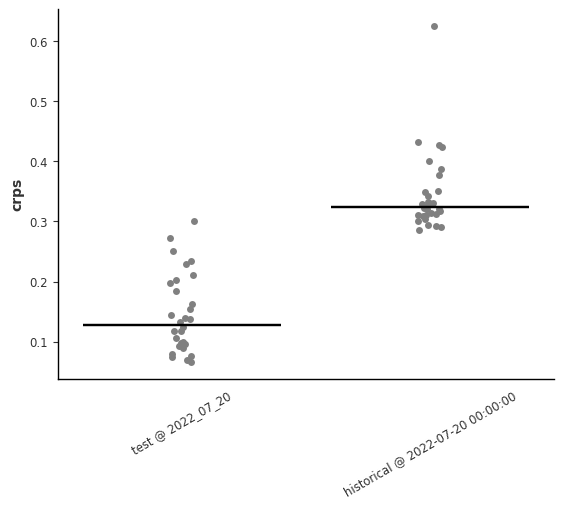

In [27]:
plot_crps_strip(['2022_07_20'], 'test', targets, 'FLNT', 'oxygen')

In [26]:
def plot_crps_strip(date_list, prefix, targets_df, site_id, target_variable, plot_name=None):
    cmap = mpl.colormaps["tab20"]
    colors = cmap.colors
    score_dict = {}
    # Loading the forecast csv and creating a time series
    for i, date_str in enumerate(date_list):
        csv_name = f"{prefix}_{date_str}.csv"
        forecast_df = pd.read_csv(csv_name)
        forecast_df["datetime"] = pd.to_datetime(forecast_df["datetime"])
        times = pd.DatetimeIndex(forecast_df["datetime"])
        forecast_df = forecast_df.set_index("datetime")

        # Getting the validation set from targets
        if i == 0:
            date = forecast_df.index[0]
            forecast_horizon = len(forecast_df)
            validation_series = get_validation_series(
                targets_df, 
                site_id, 
                target_variable, 
                date, 
                forecast_horizon,
            )
        # Filter the forecast to only include dates with observations
        filtered_model_forecast, filtered_validation_series = filter_forecast_df(
            forecast_df,
            validation_series
        )
        # Computing CRPS and plotting it as well as its mean (dashed)
        scores = crps(
            filtered_model_forecast, 
            filtered_validation_series
        )
        key_name = prefix + " @ " + date.strftime('%Y_%m_%d')
        score_dict[key_name] = scores.pd_dataframe().values[:, 0]
            
        # Now, making the forecast based off of historical mean and std
        historical_model = HistoricalForecaster(targets=targets_df,
                              site_id=site_id,
                              target_variable=target_variable,
                              output_csv_name="historical_forecaster_output.csv",
                              validation_split_date=str(forecast_df.index[0])[:10],
                              forecast_horizon=len(forecast_df),)
        # Computing CRPS of historical forecast and plotting
        historical_model.make_forecasts()
        historical_forecast_df = historical_model.forecast_ts.pd_dataframe(
            suppress_warnings=True
        )
        filtered_historical_forecast, filtered_validation_series = filter_forecast_df(
            historical_forecast_df,
            validation_series
        )
        scores = crps(filtered_historical_forecast, filtered_validation_series)
        score_dict[f"historical @ {date}"] = scores.pd_dataframe().values[:, 0]

    # Now creating the plot
    p = sns.stripplot(score_dict, jitter=0.05, color='0.5')

    # plot the mean line
    sns.boxplot(
        showmeans=False,
        meanline=False,
        meanprops={'color': 'k', 'ls': '-', 'lw': 2},
        medianprops={'visible': True, 'lw':1.75},
        whiskerprops={'visible': False},
        zorder=10,
        data=score_dict,
        showfliers=False,
        showbox=False,
        showcaps=False,
        ax=p
    )
    plt.grid(False)
    plt.ylabel("crps")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    
    # Saving the plot if desired
    if plot_name != None:
        if not os.path.exists(f"plots/{site_id}/{target_variable}/"):
            os.makedirs(f"plots/{site_id}/{target_variable}/")
        plt.savefig(f"plots/{site_id}/{target_variable}/{plot_name}")

/tmp/ipykernel_12310/500773995.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16, 12))


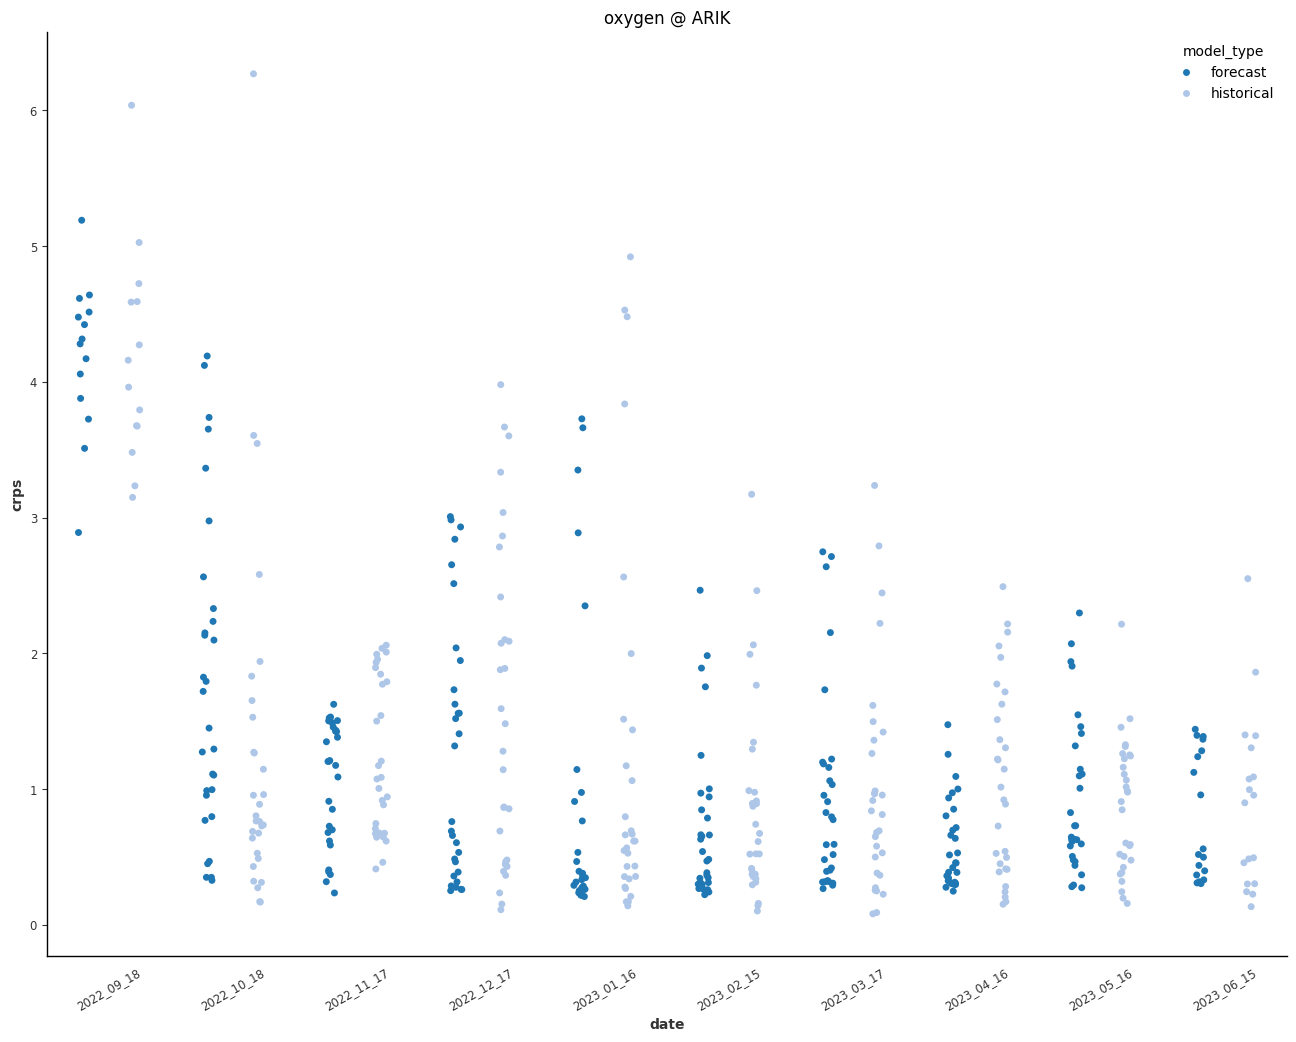

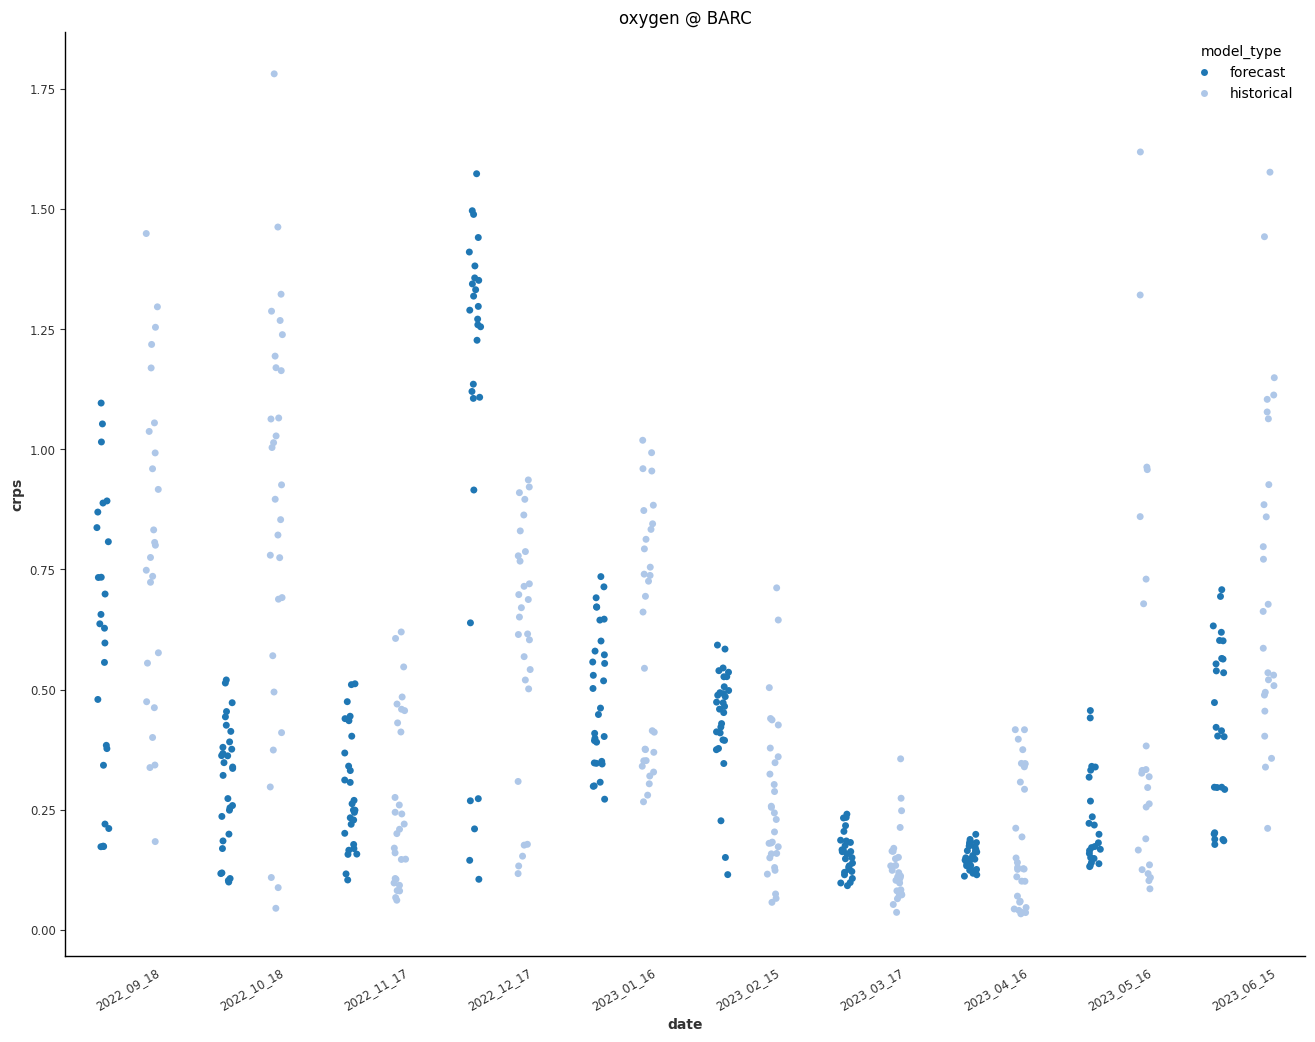

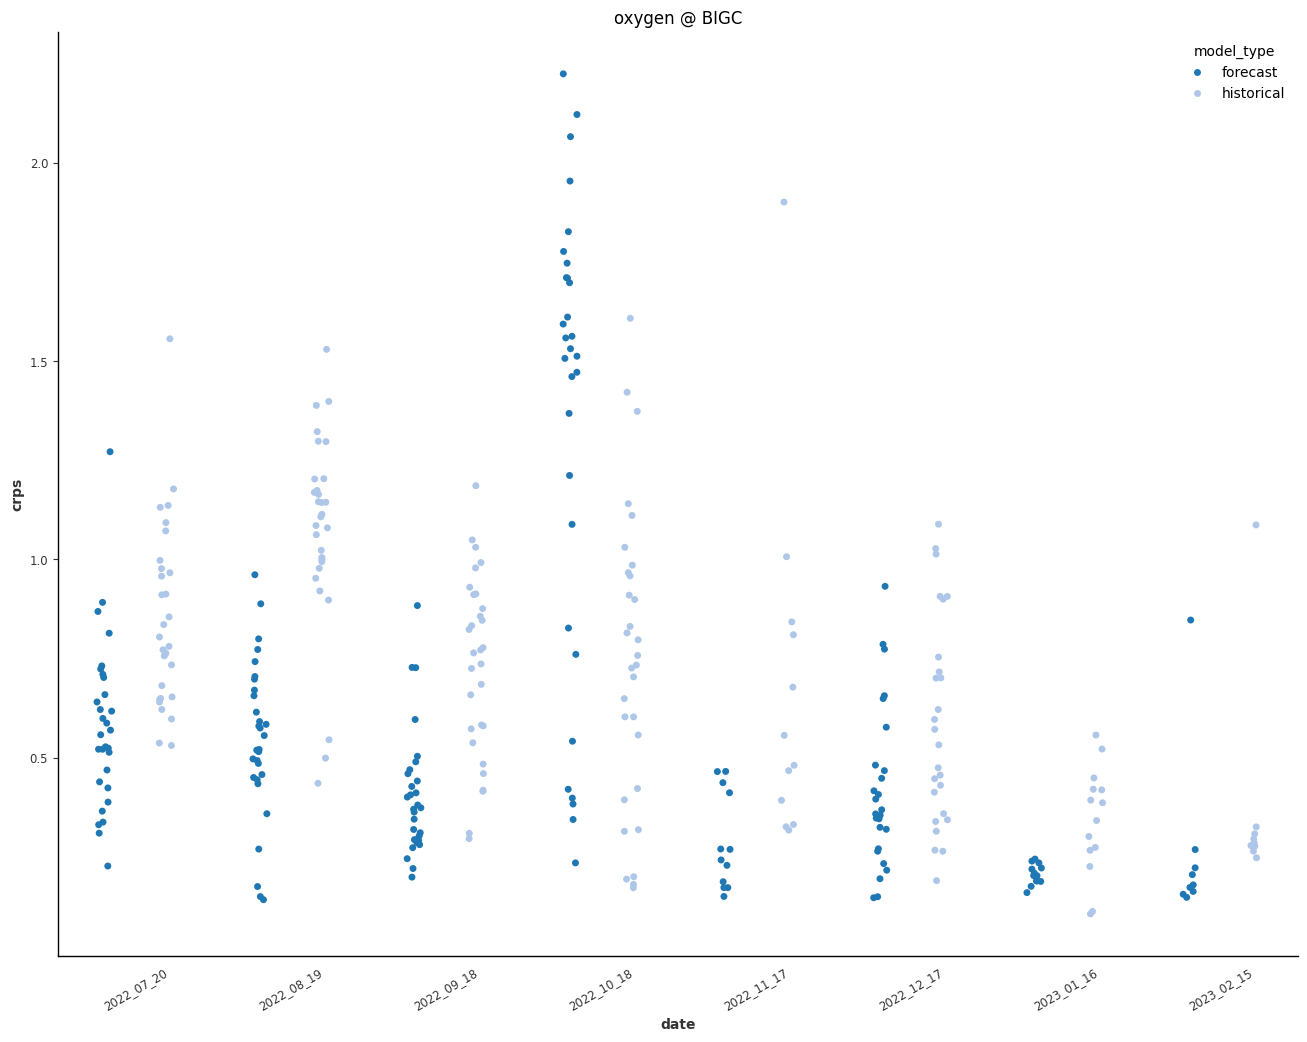

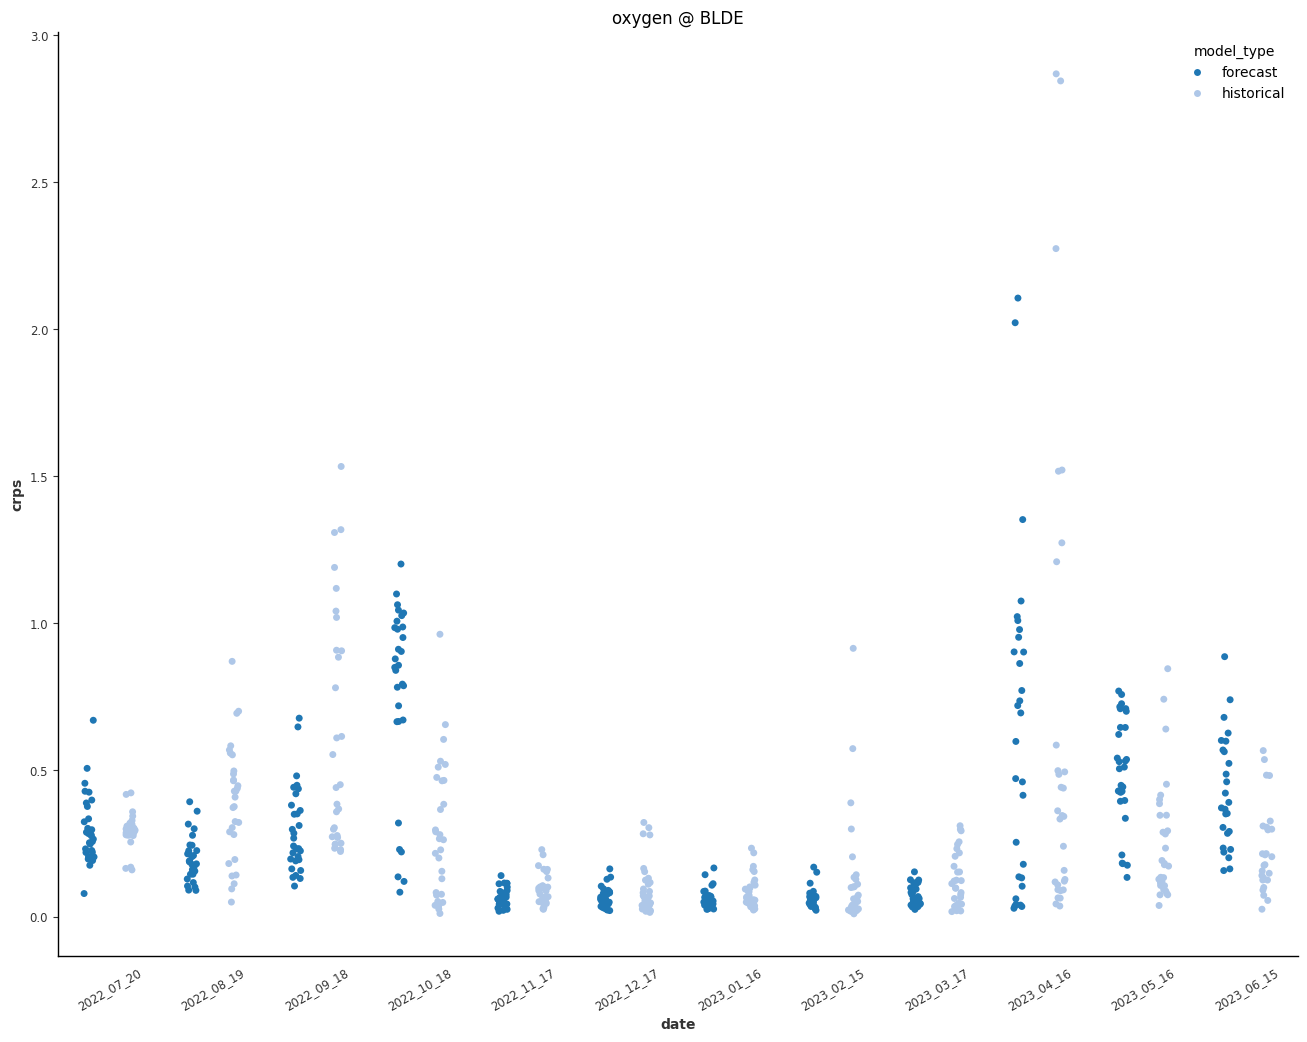

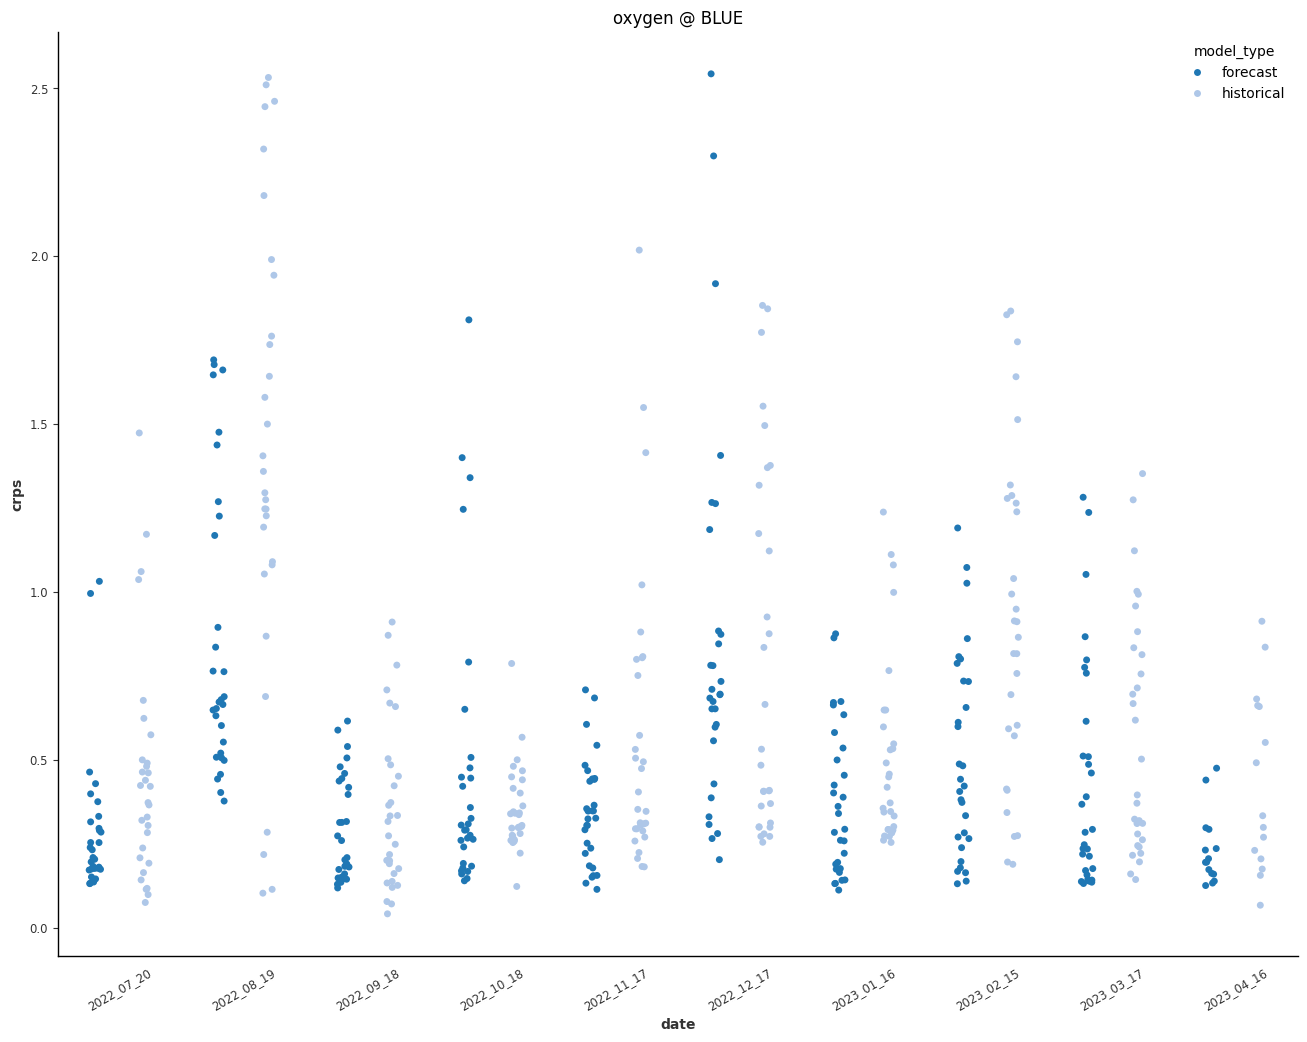

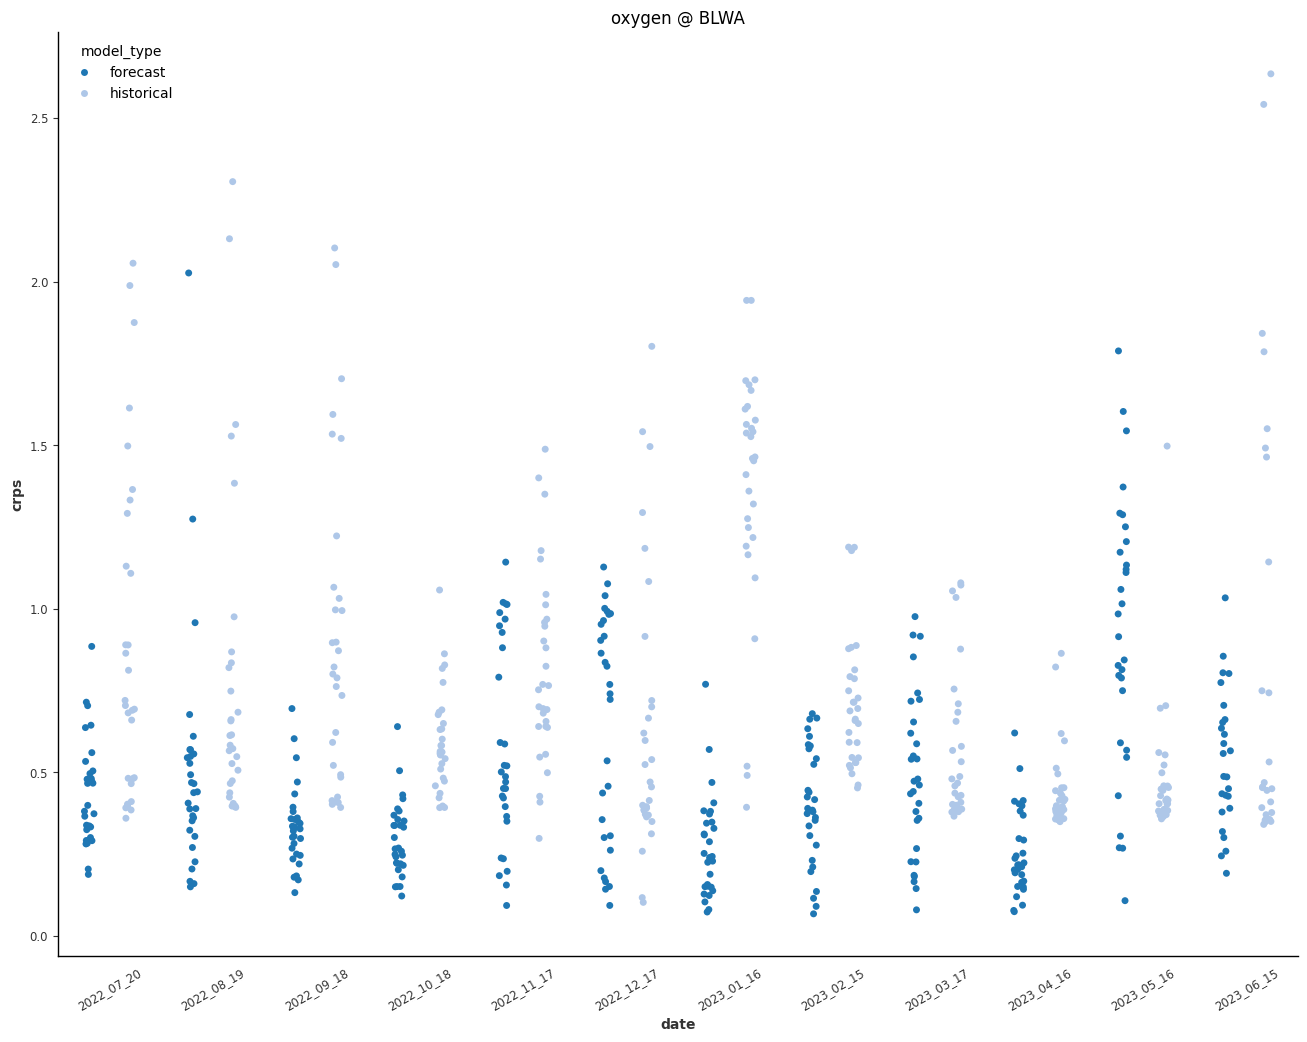

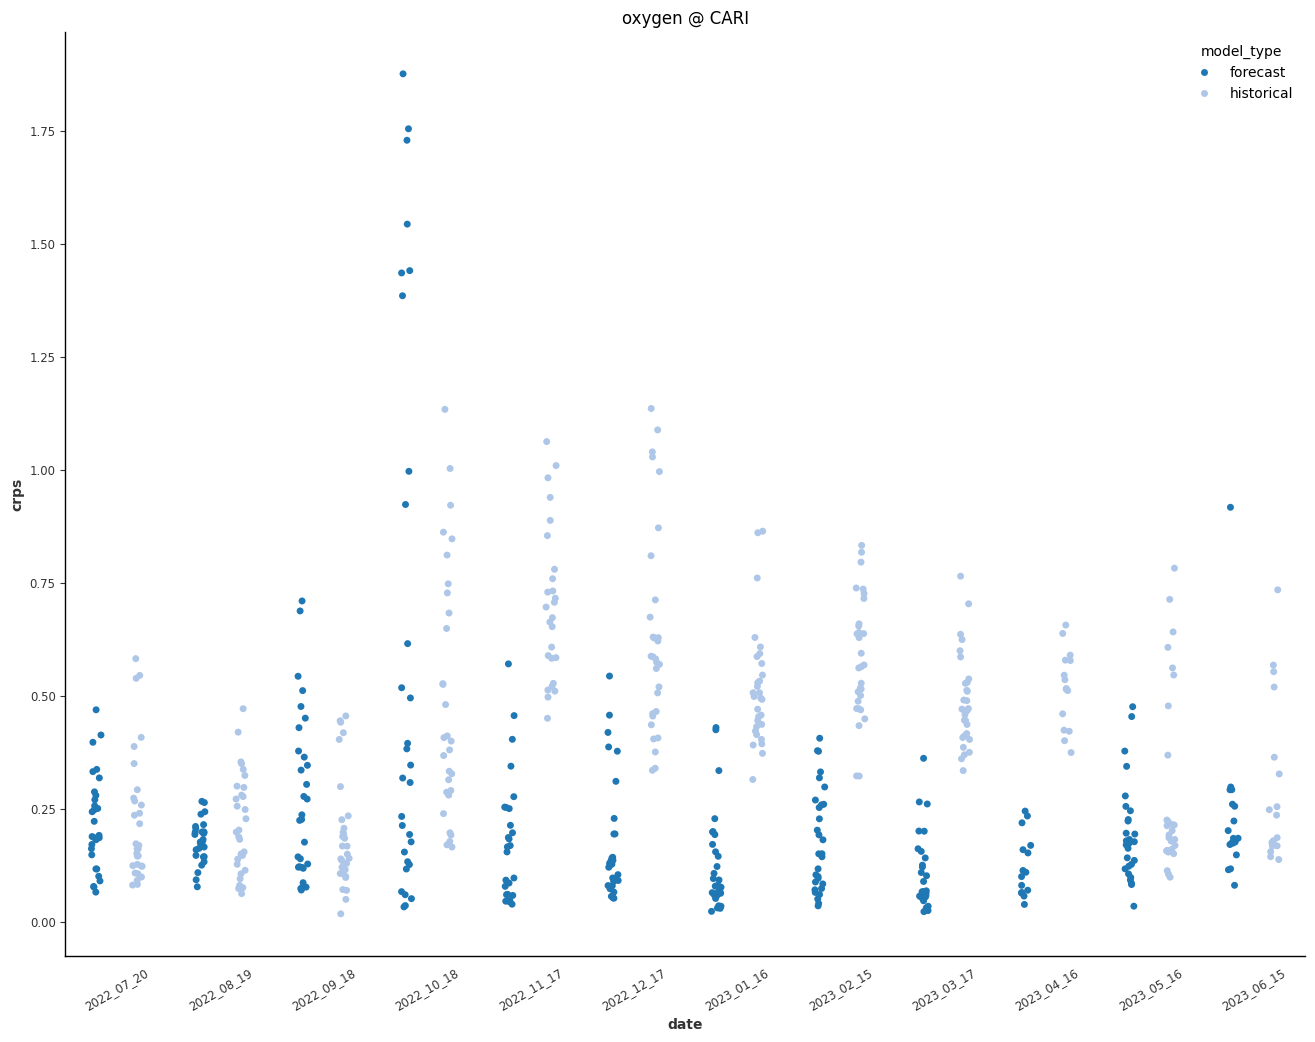

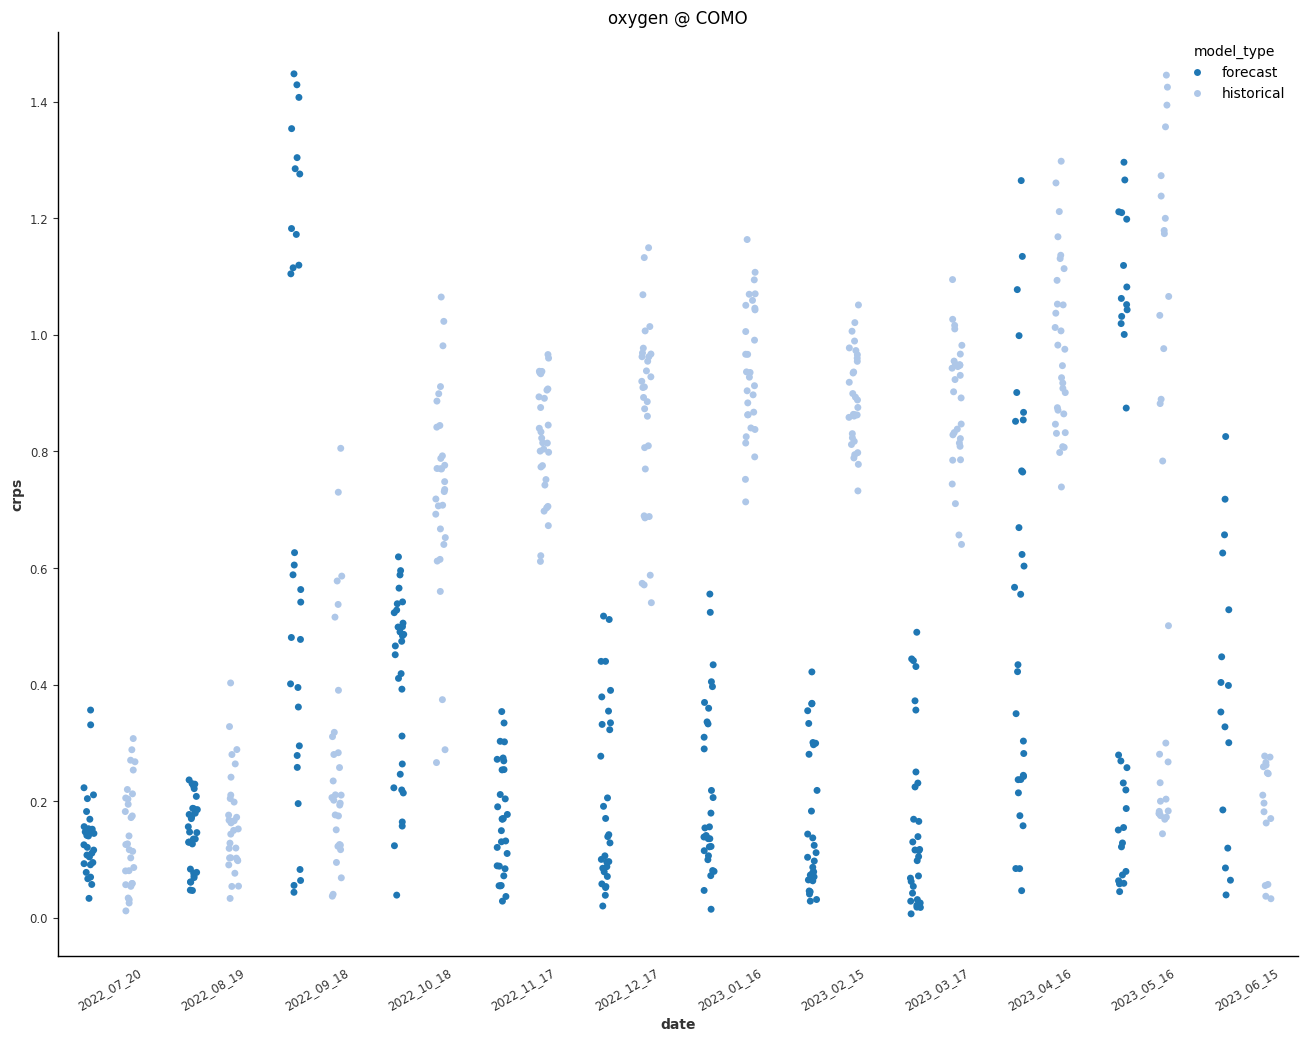

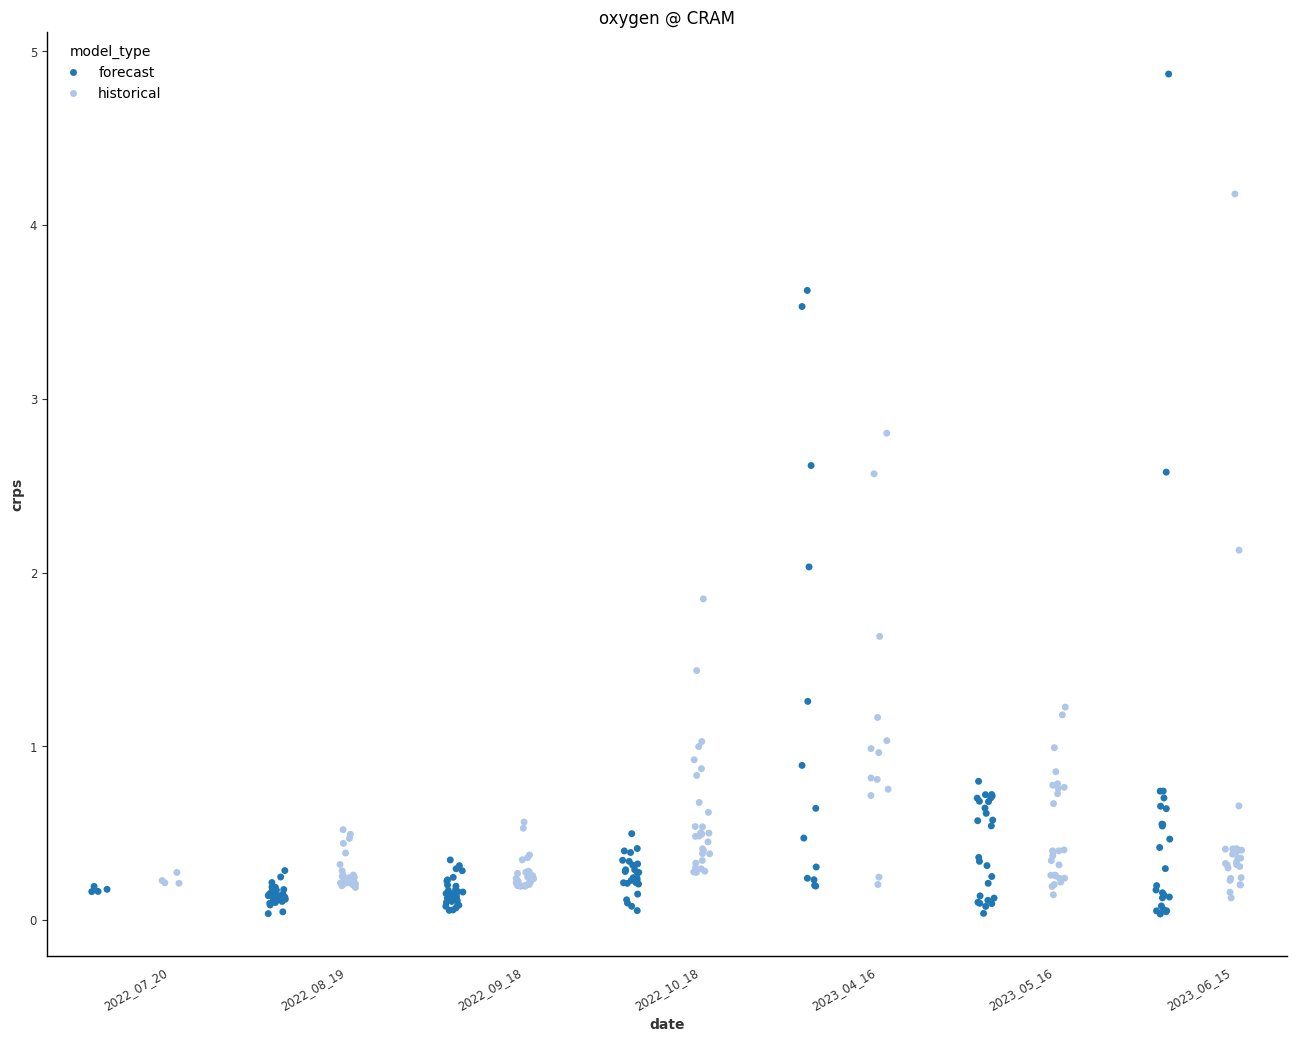

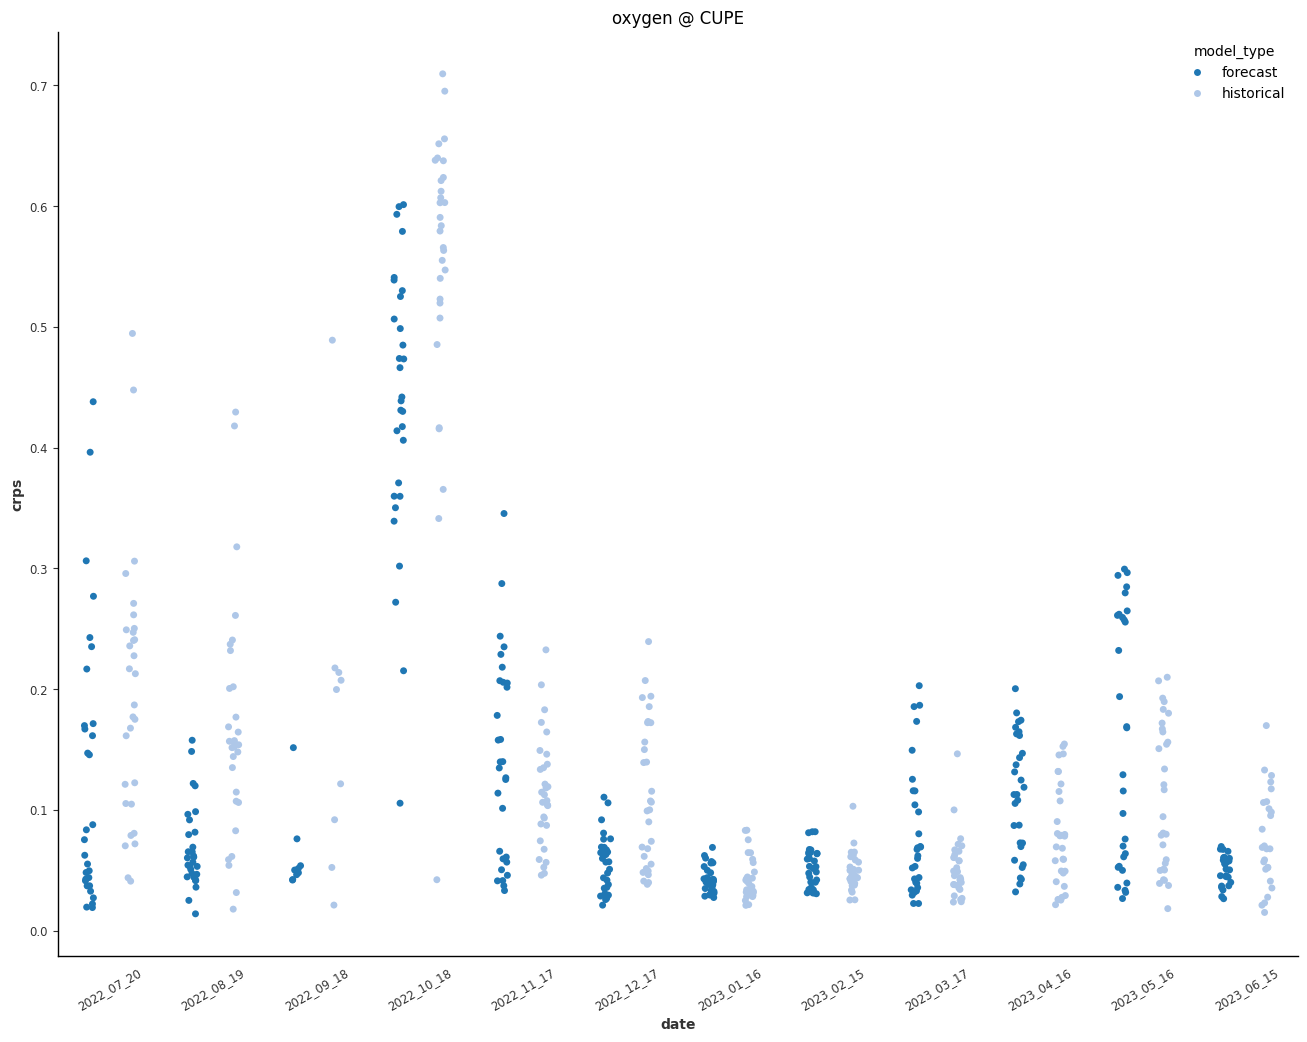

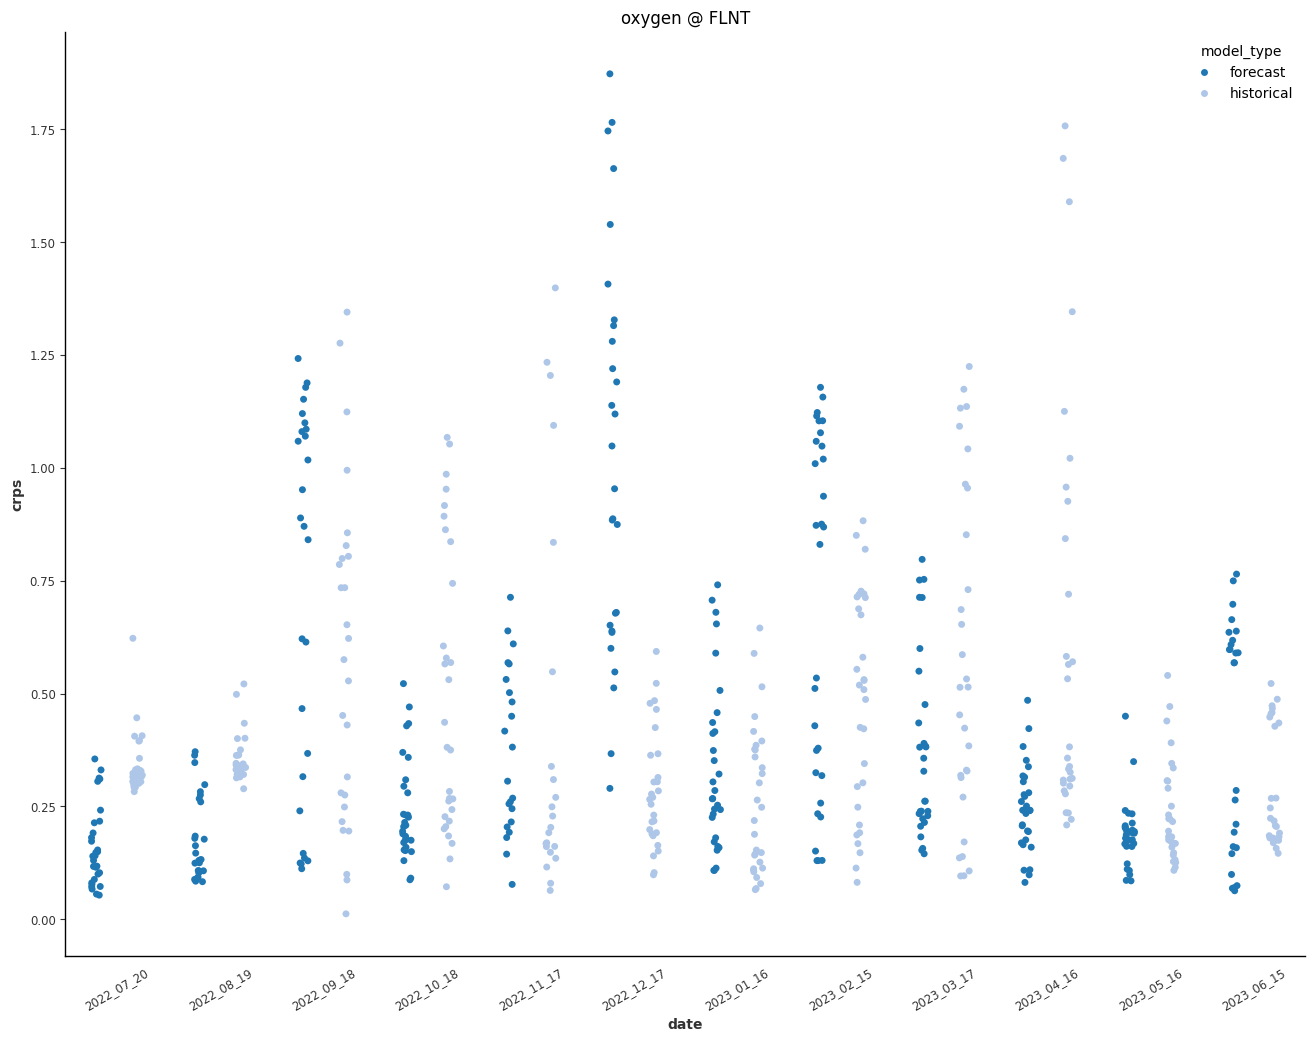

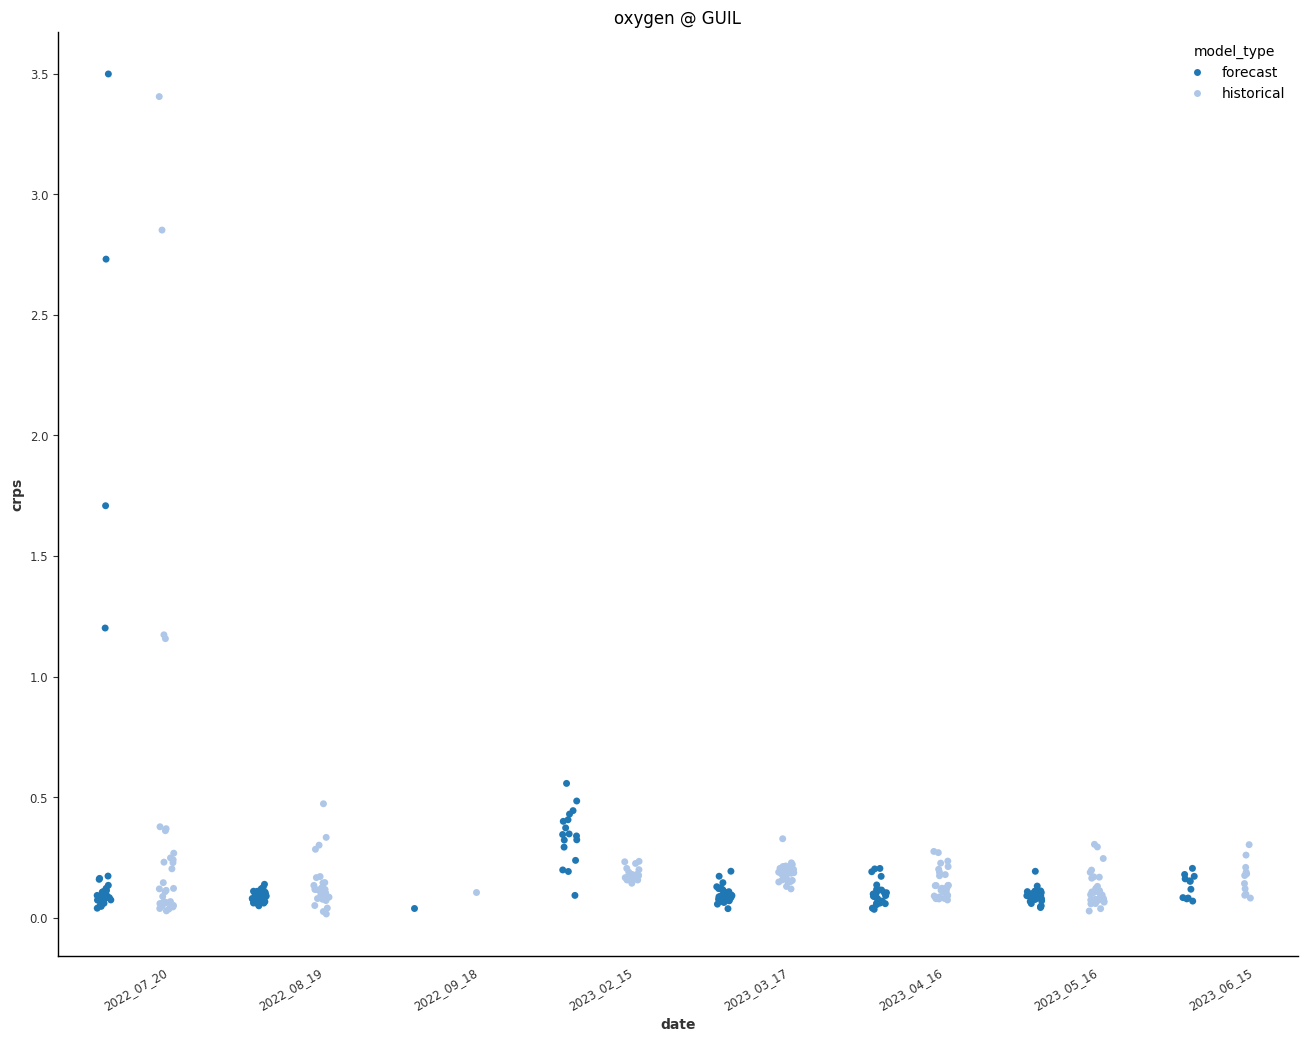

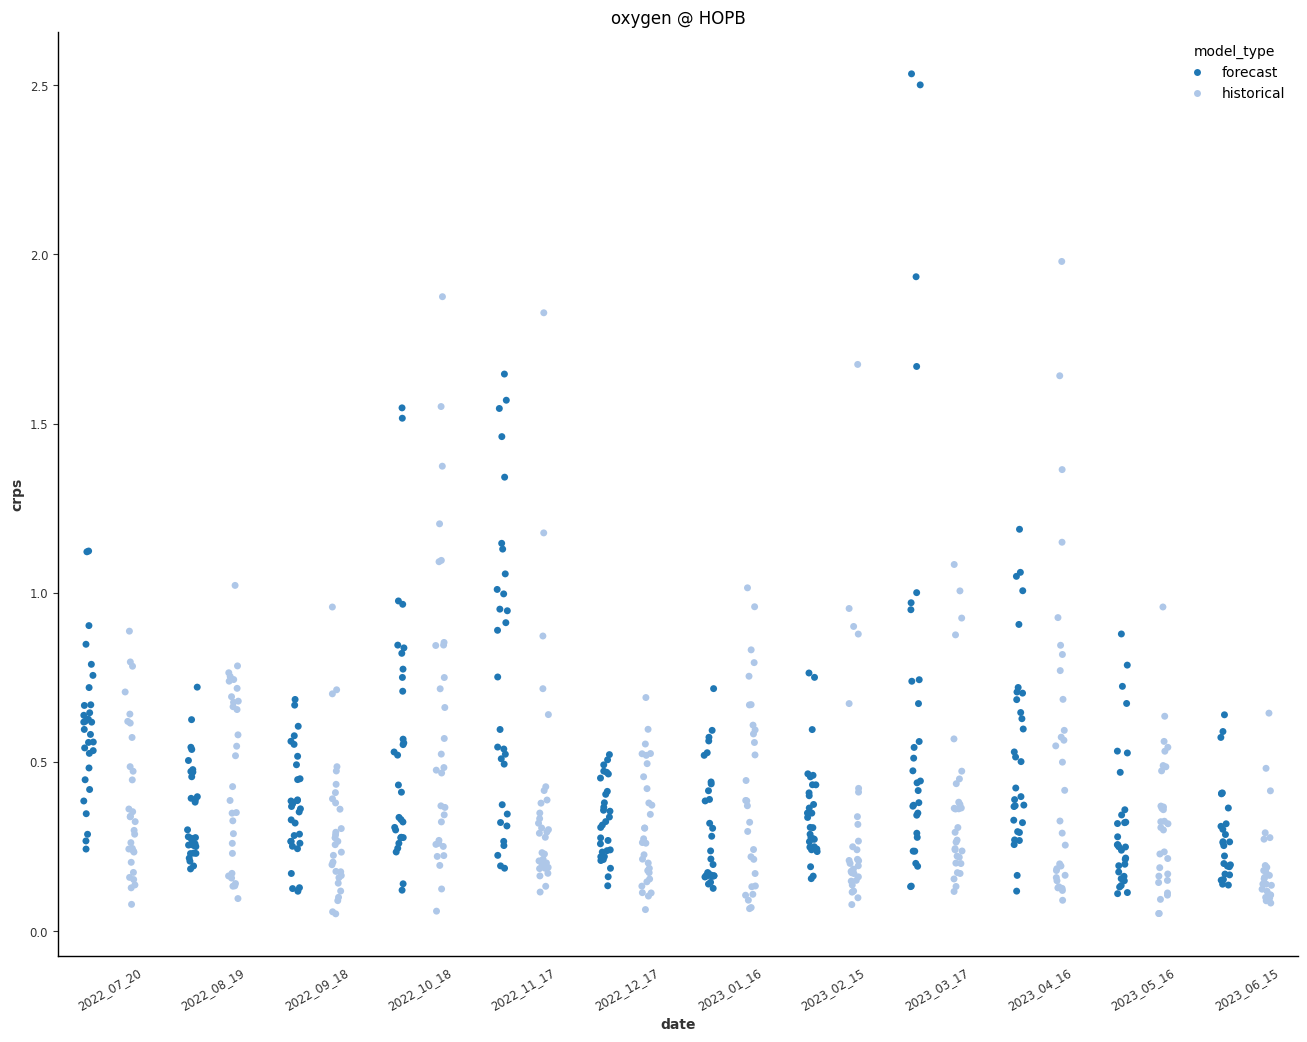

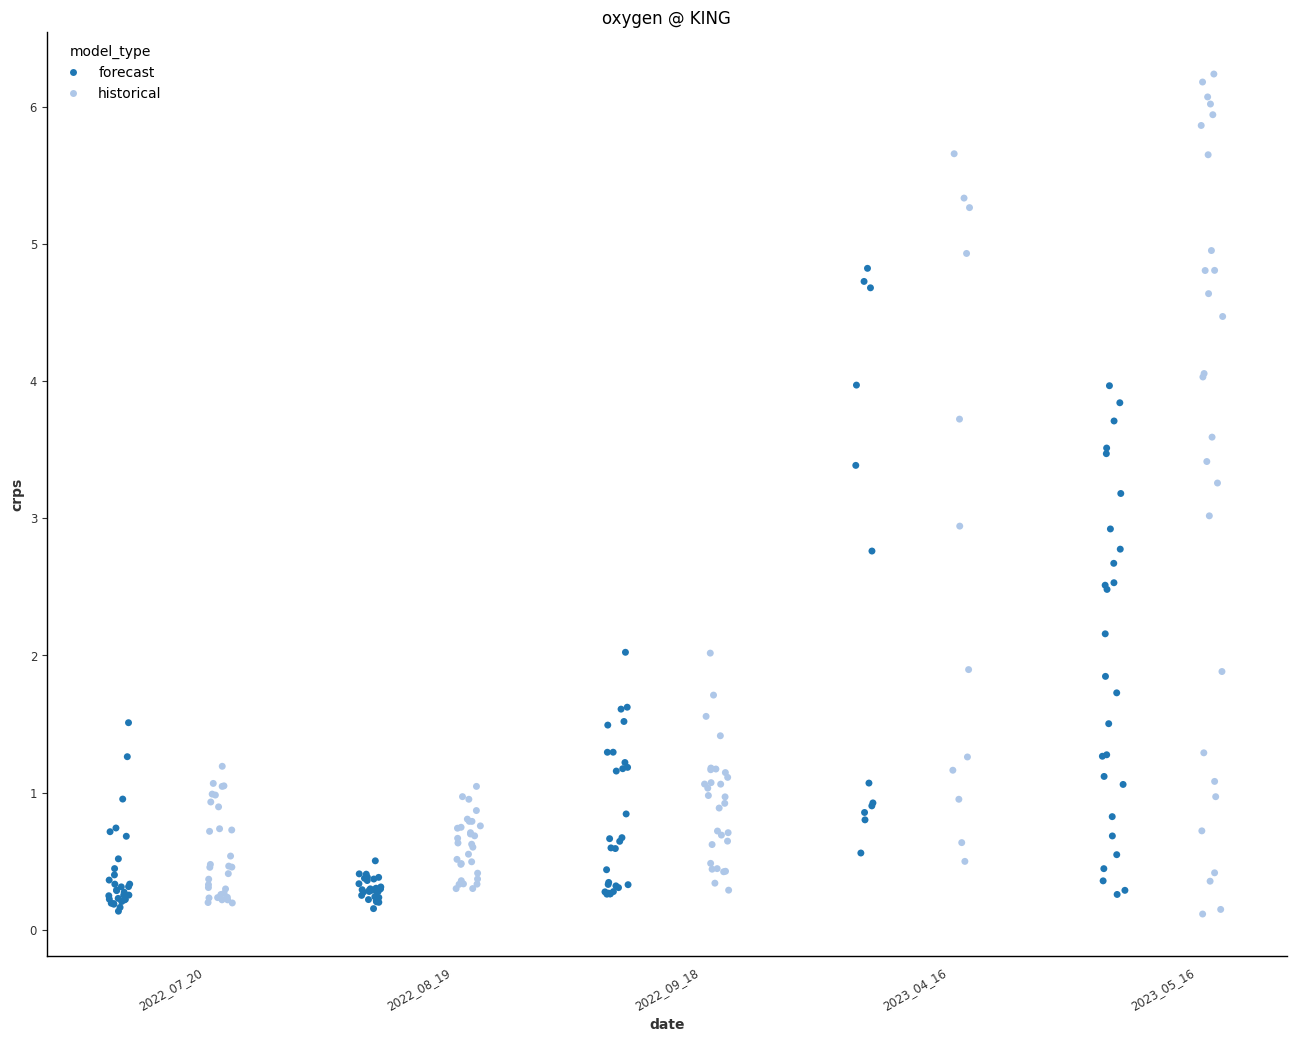

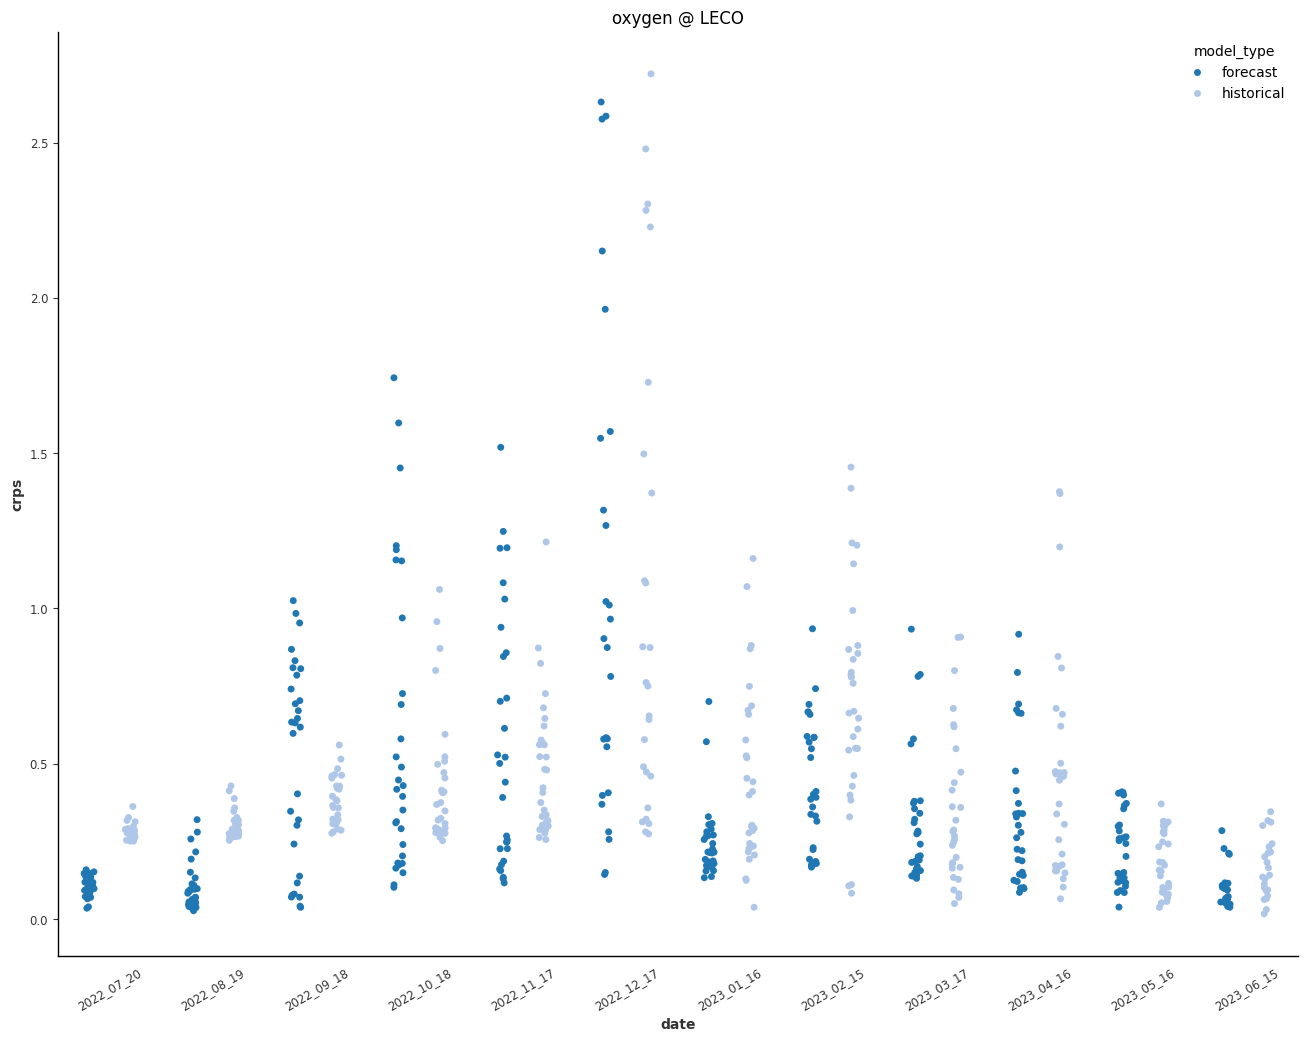

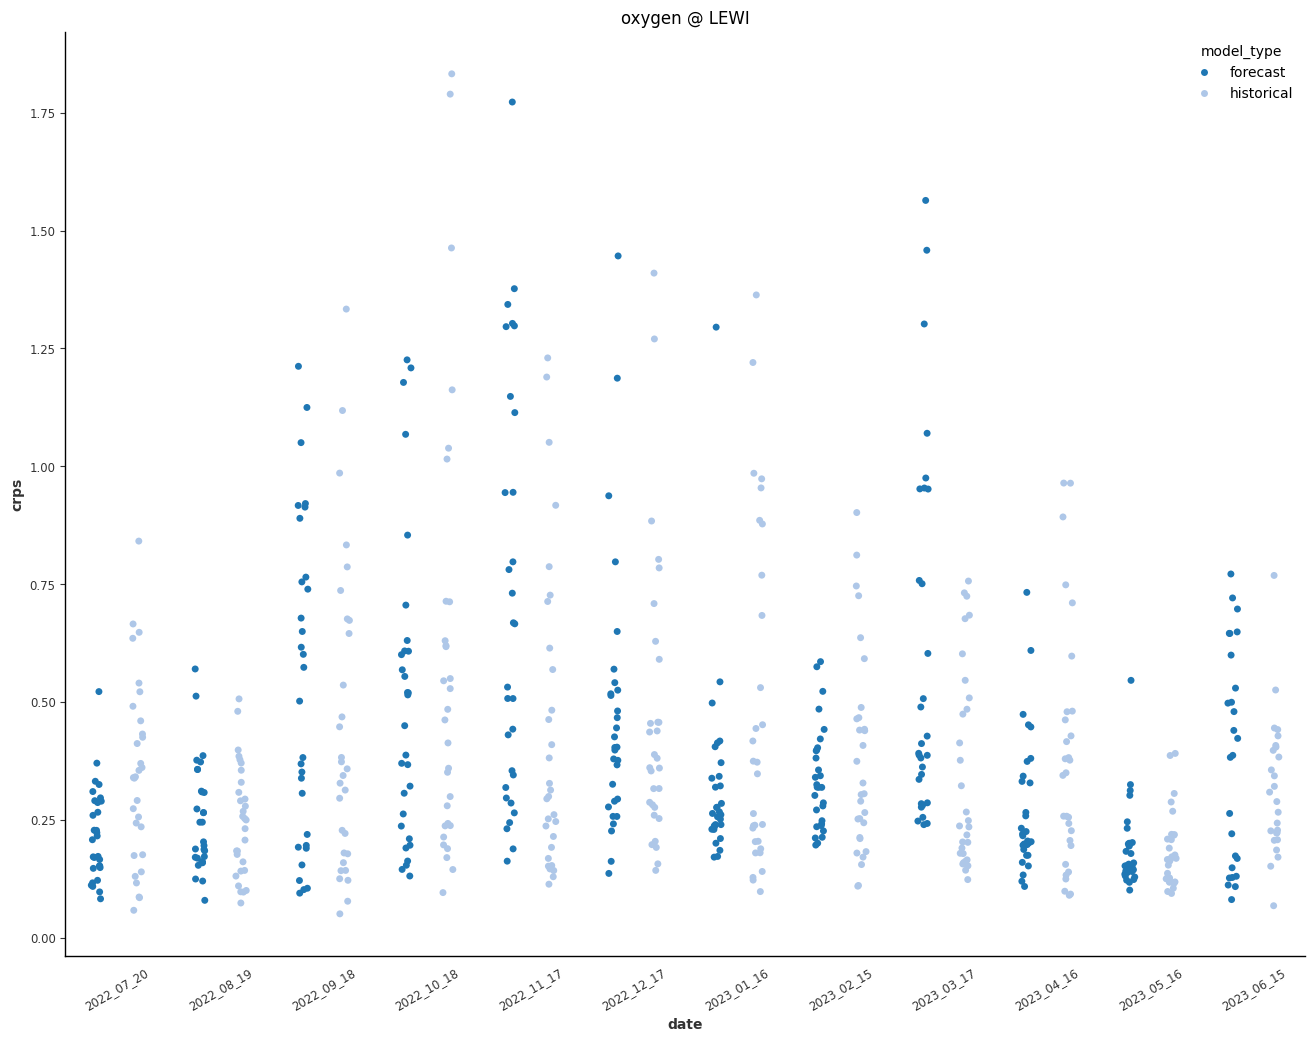

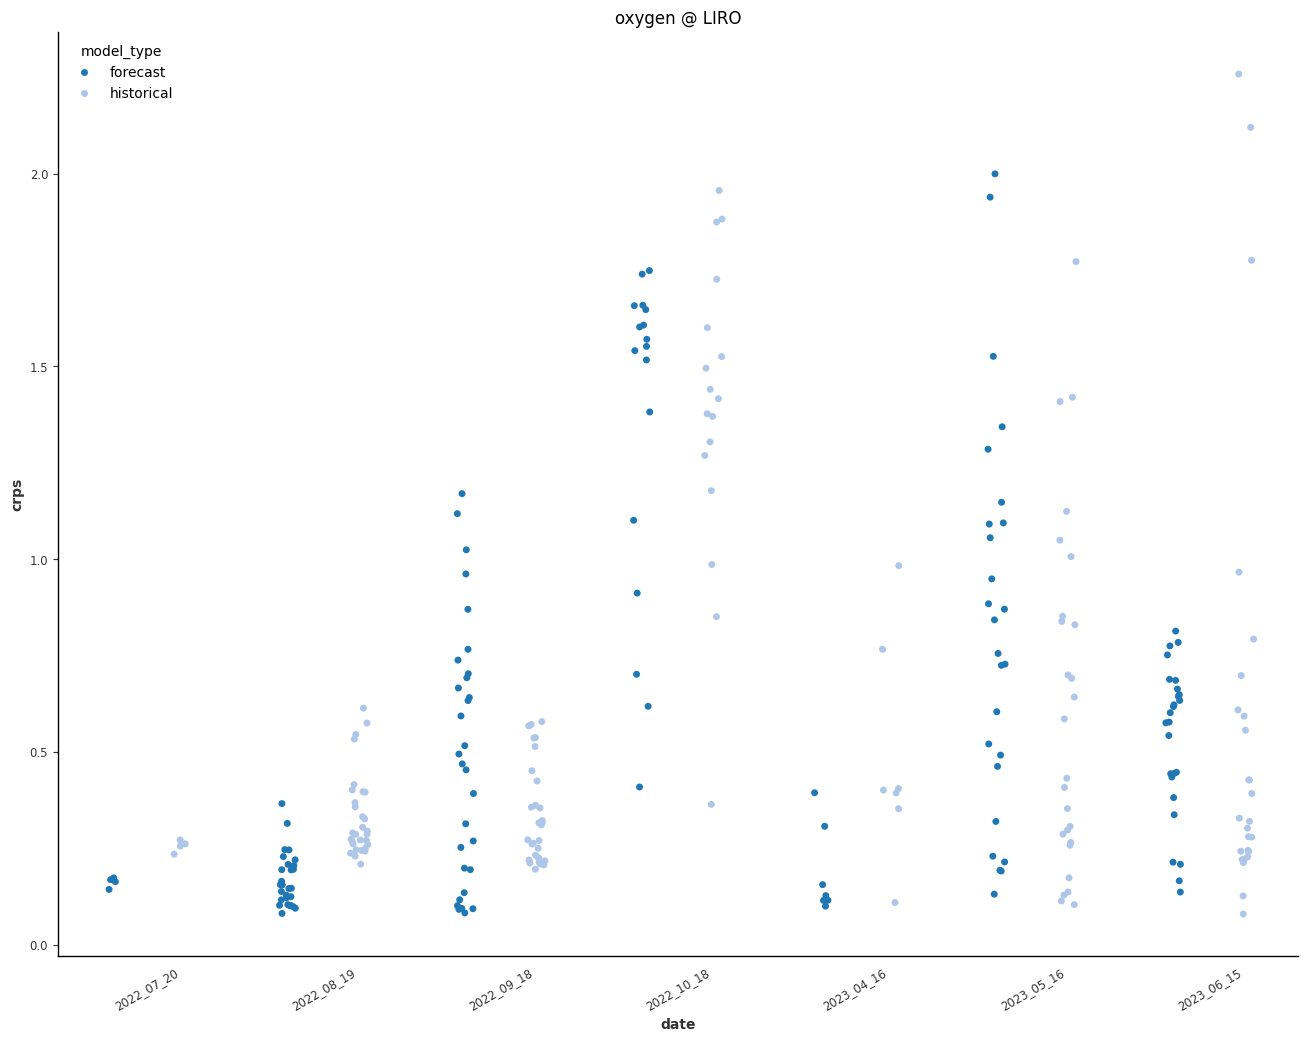

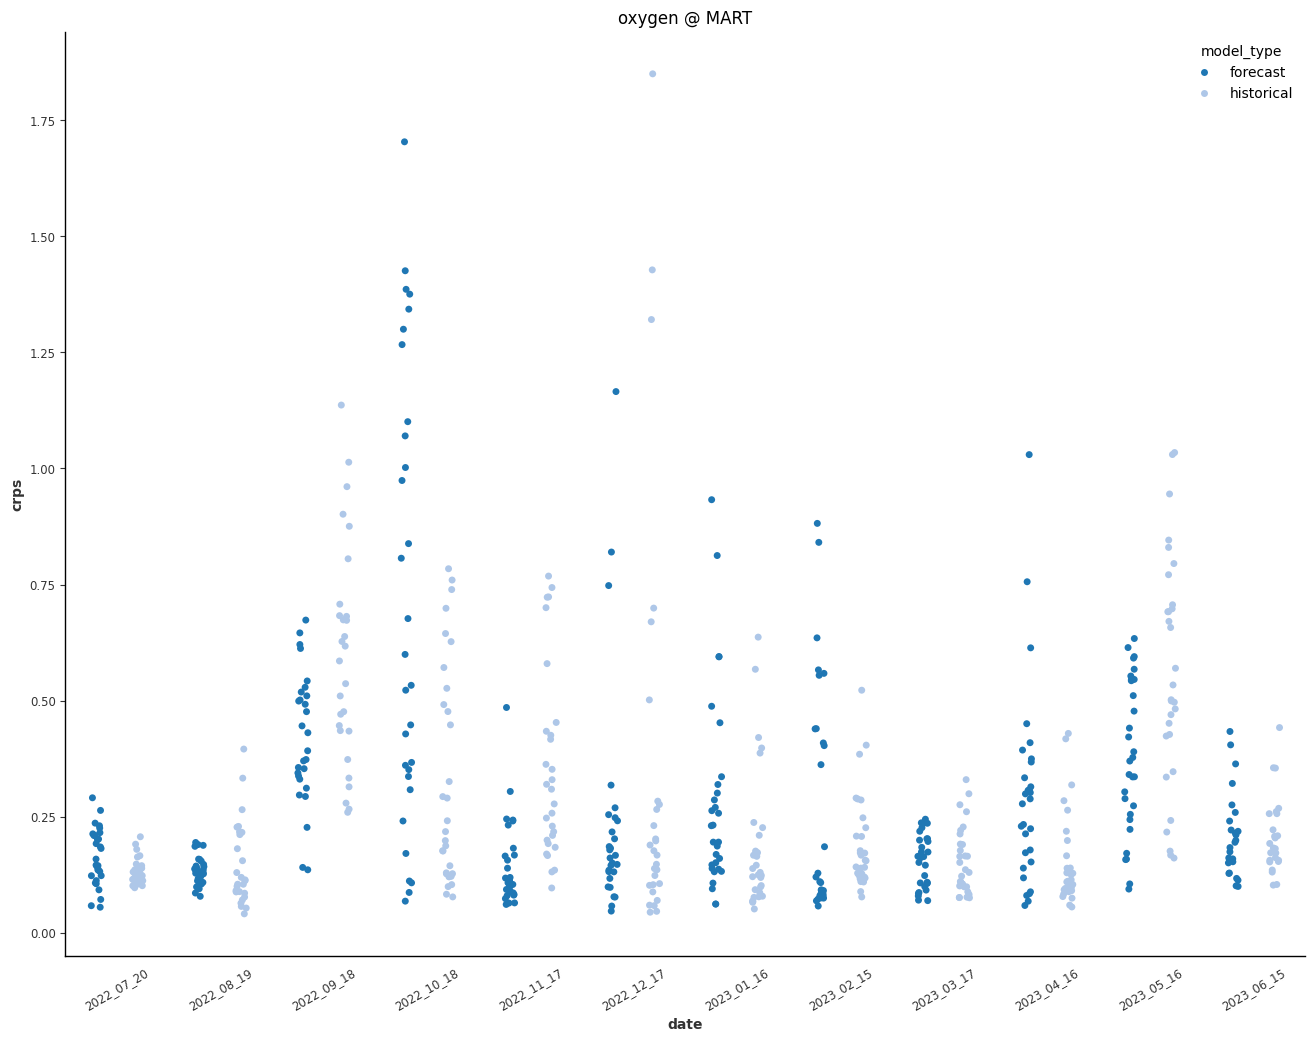

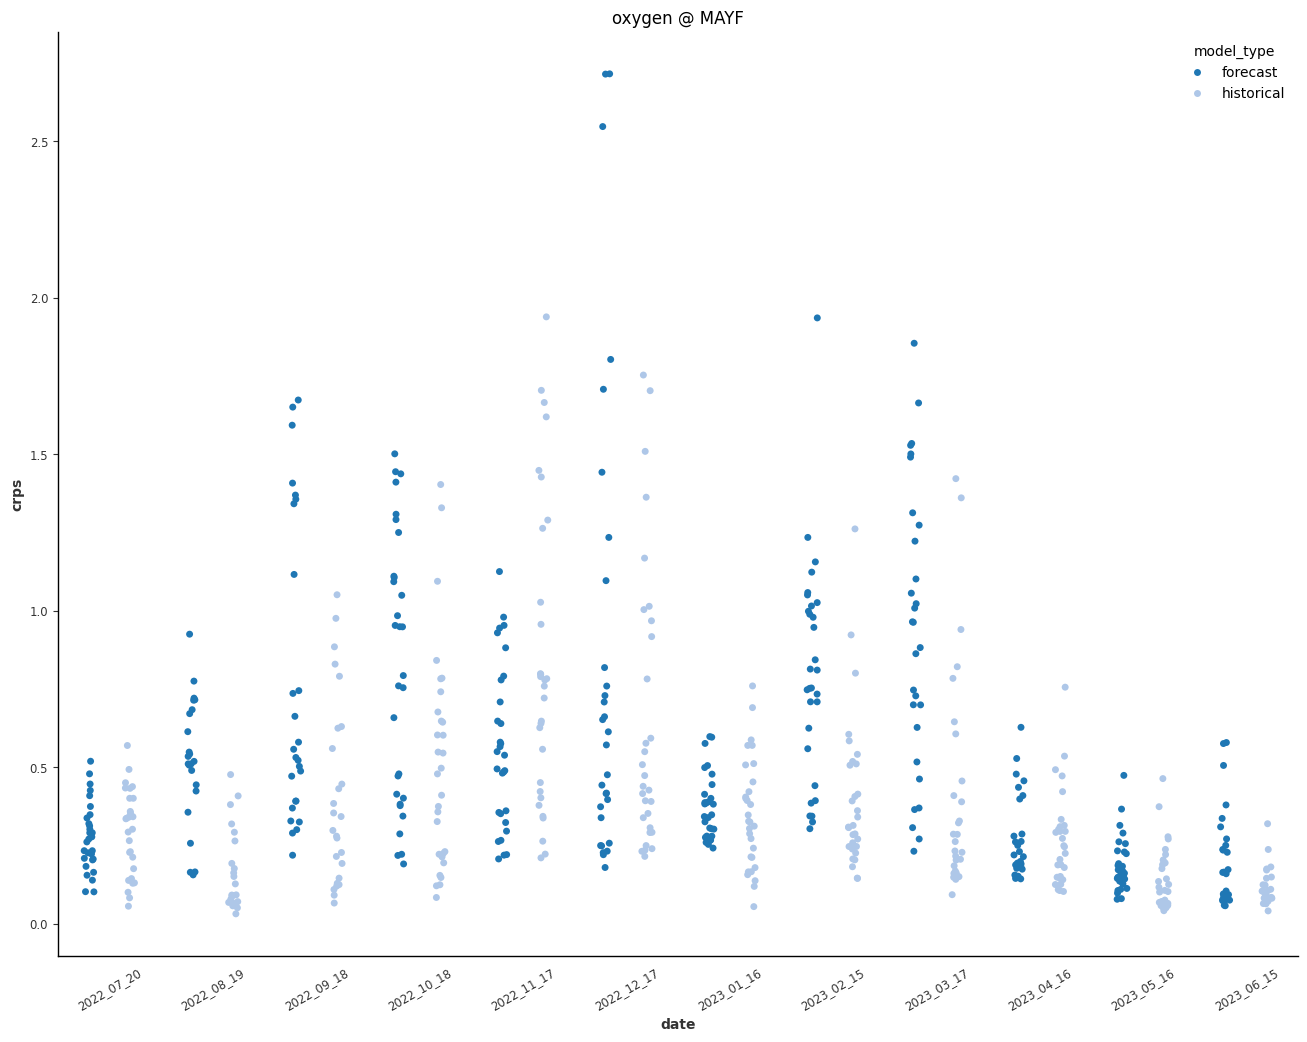

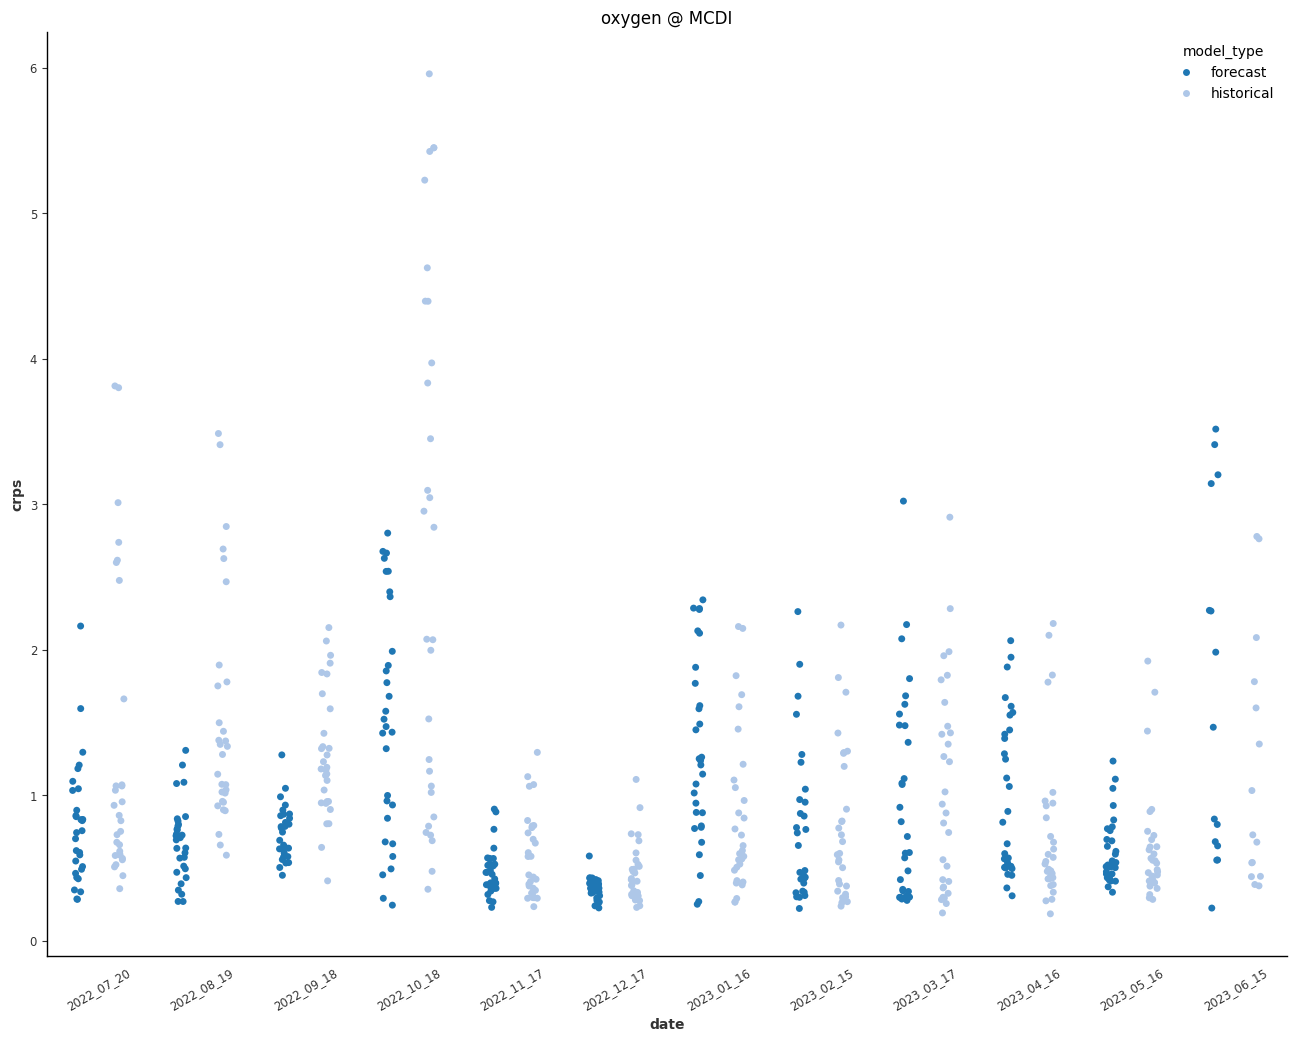

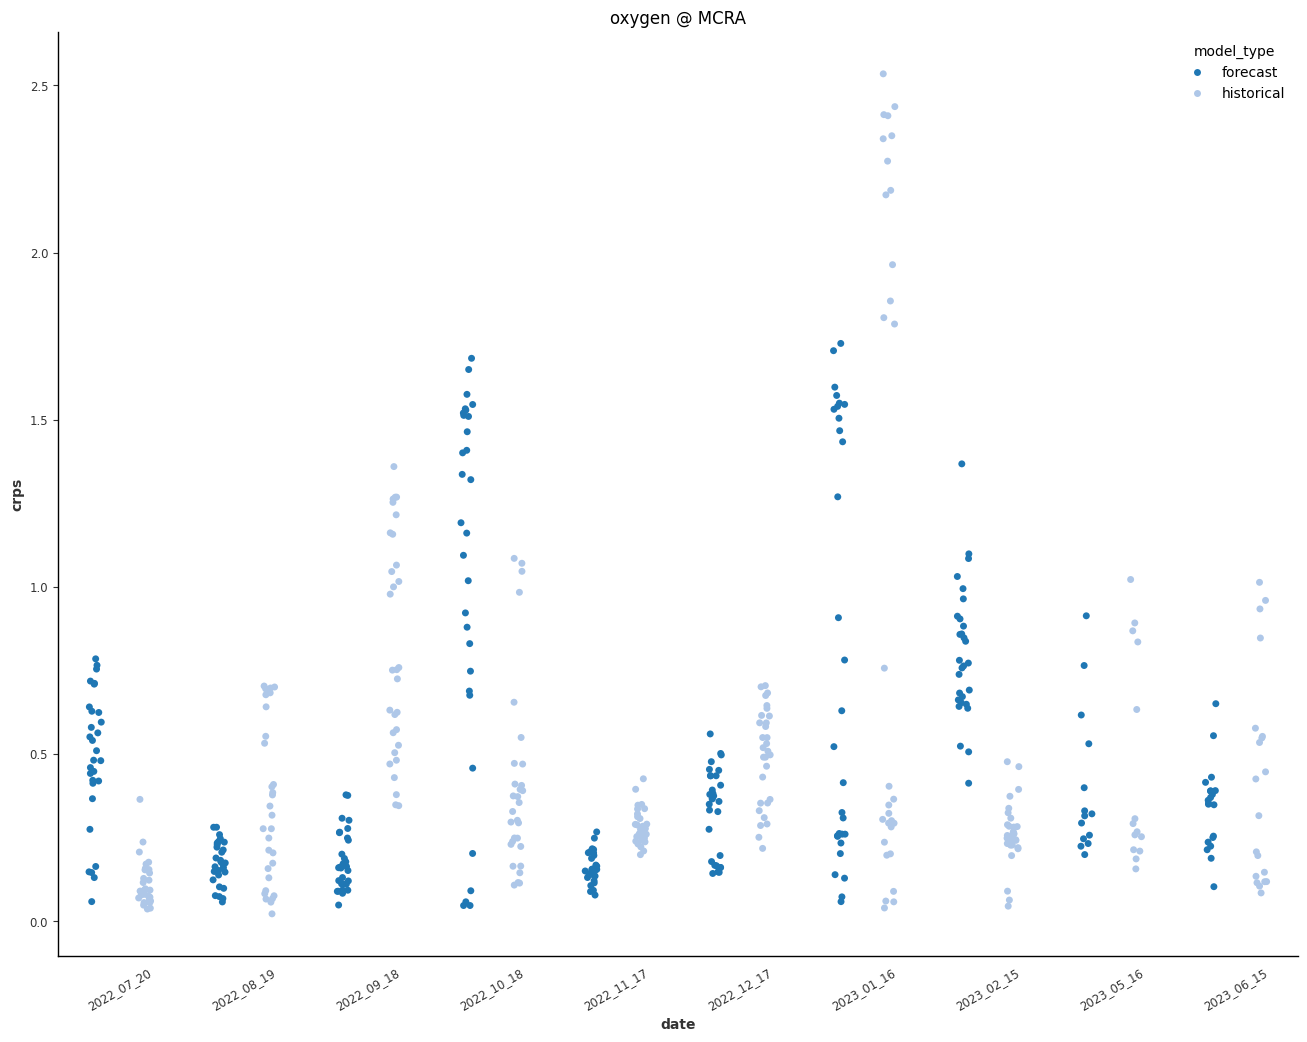

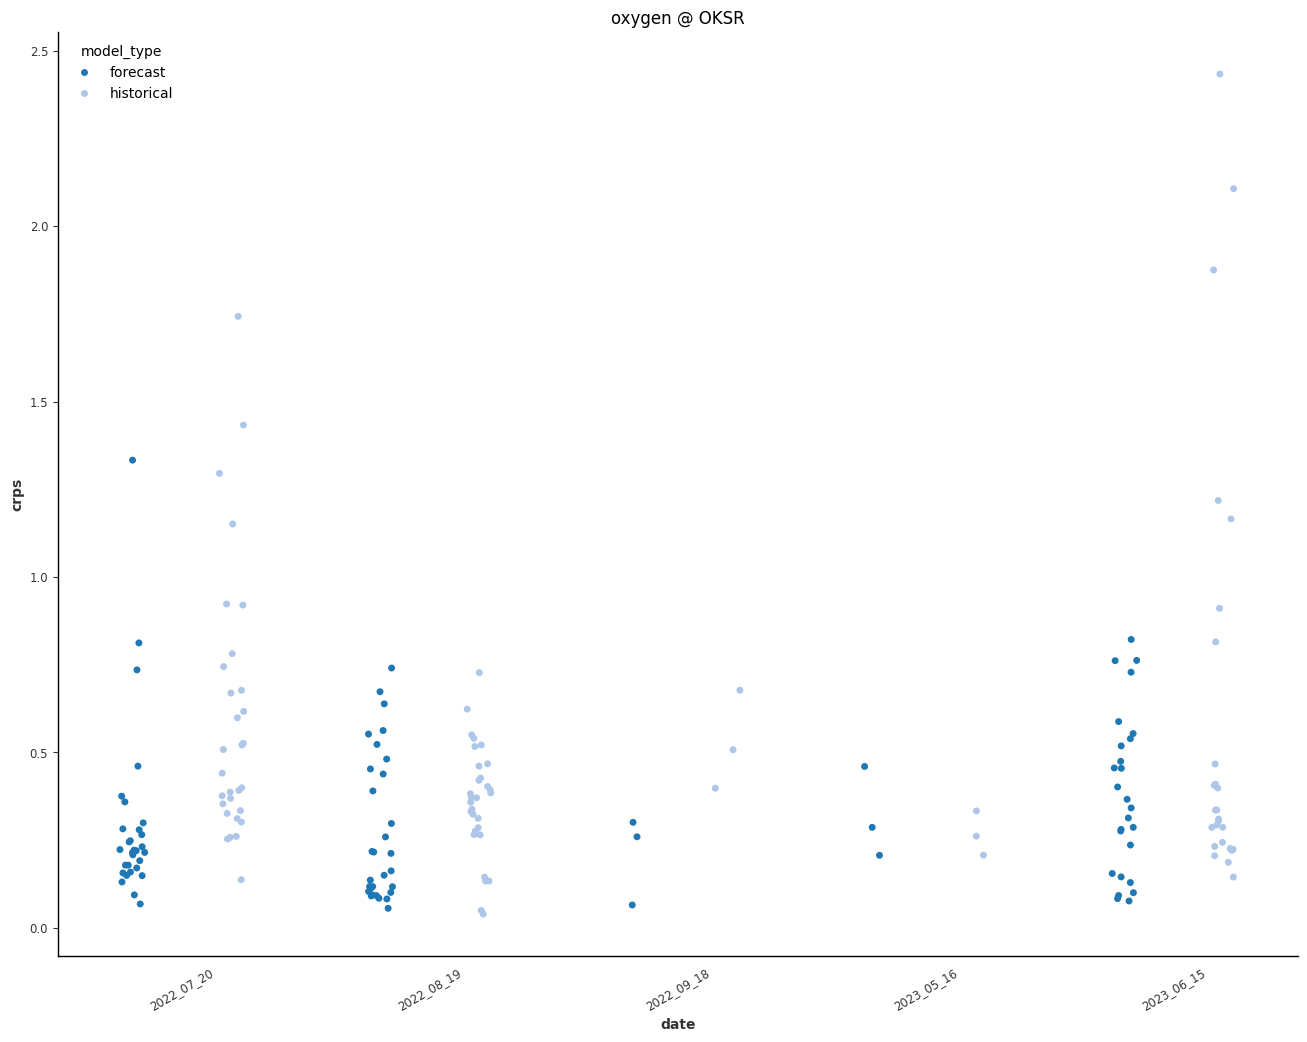

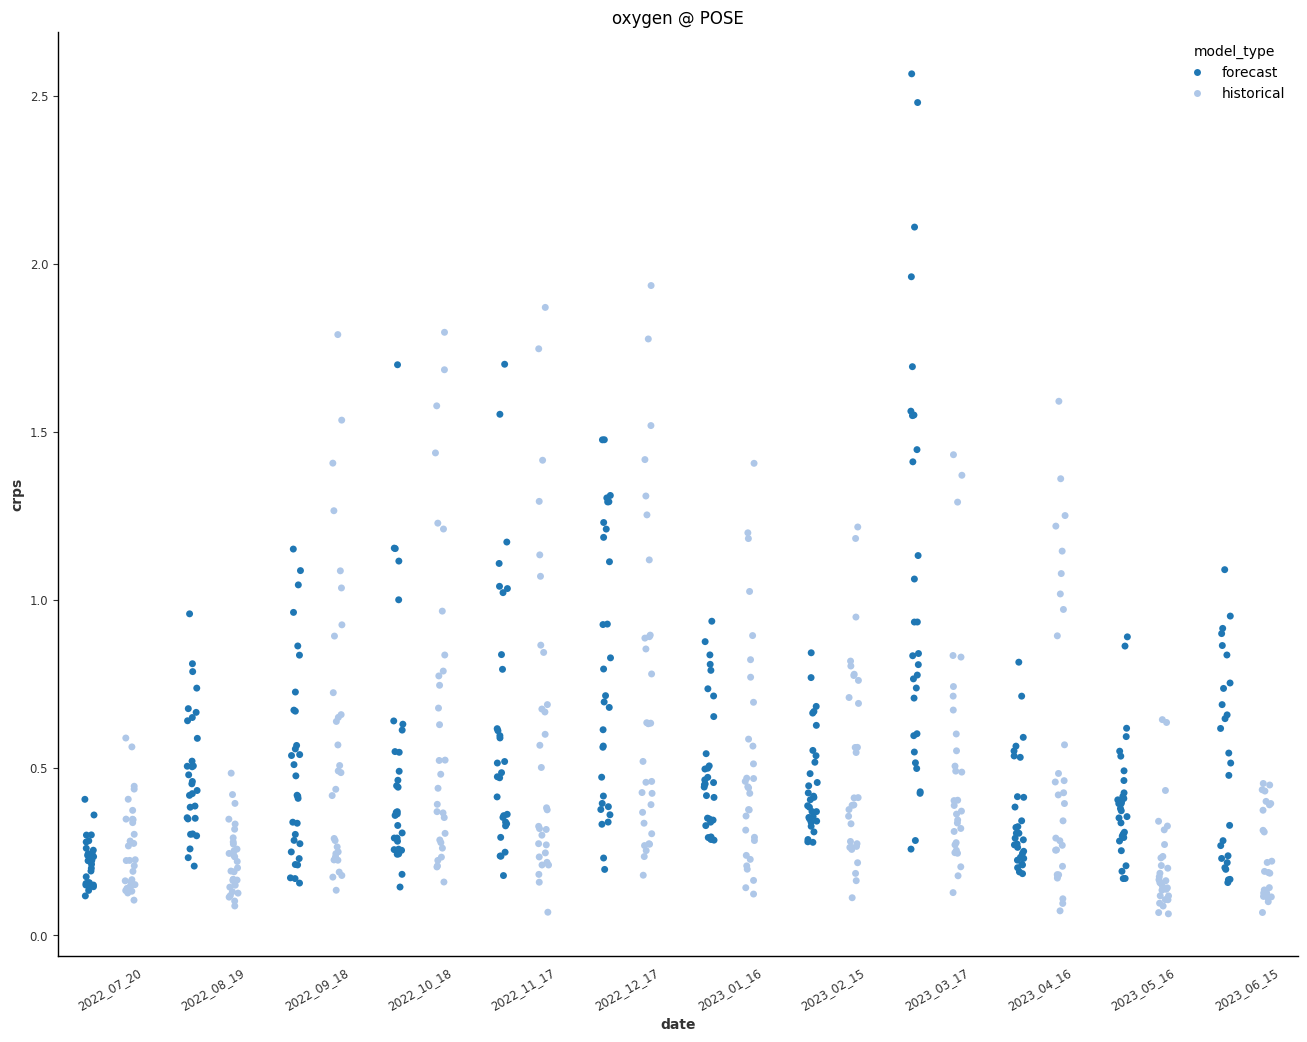

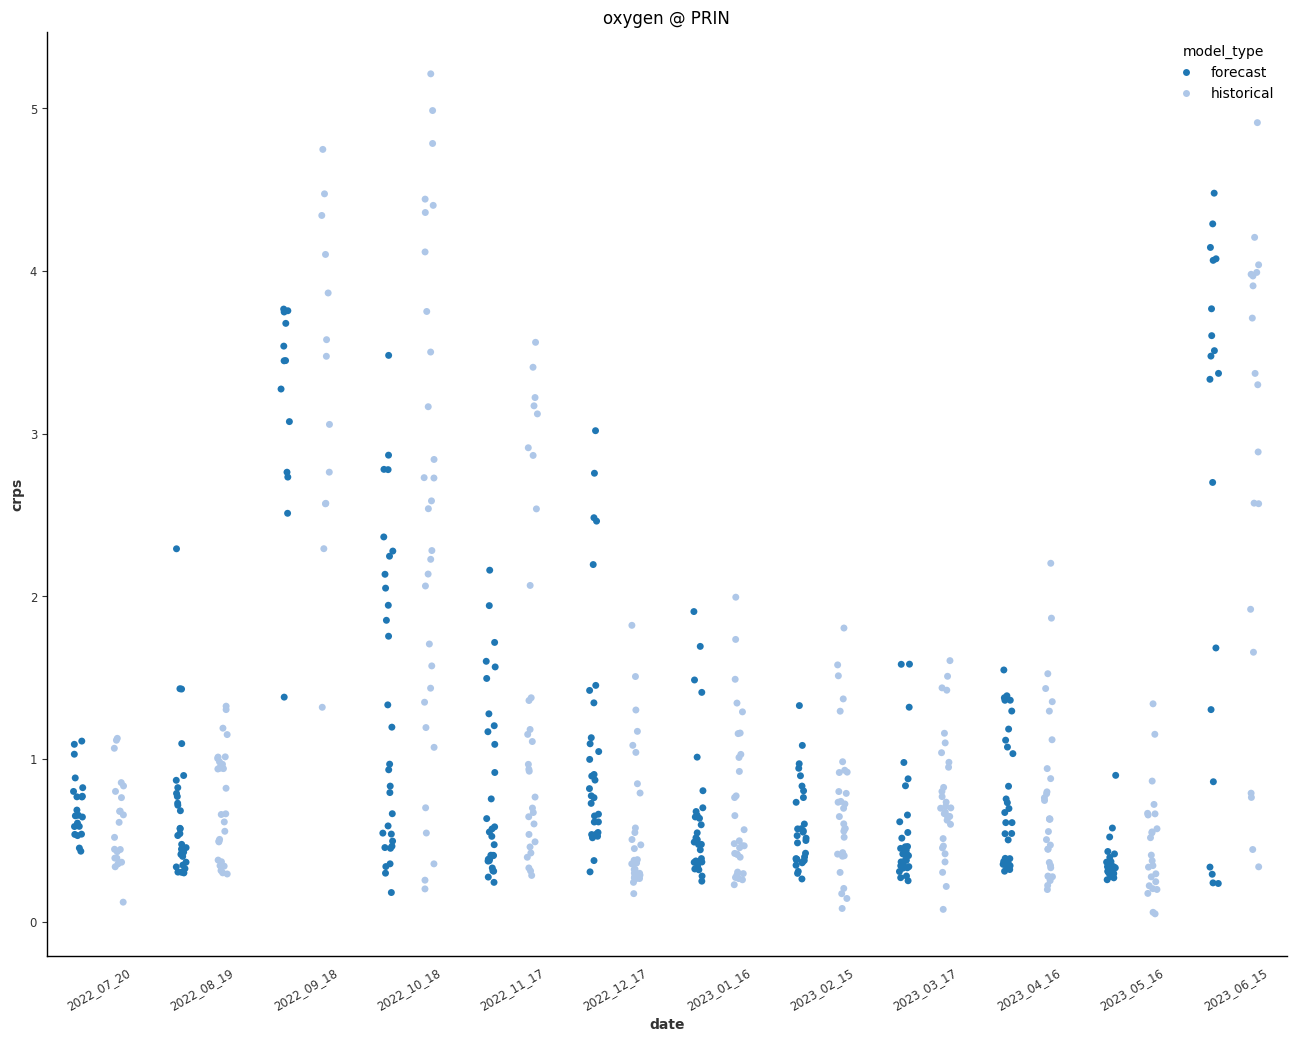

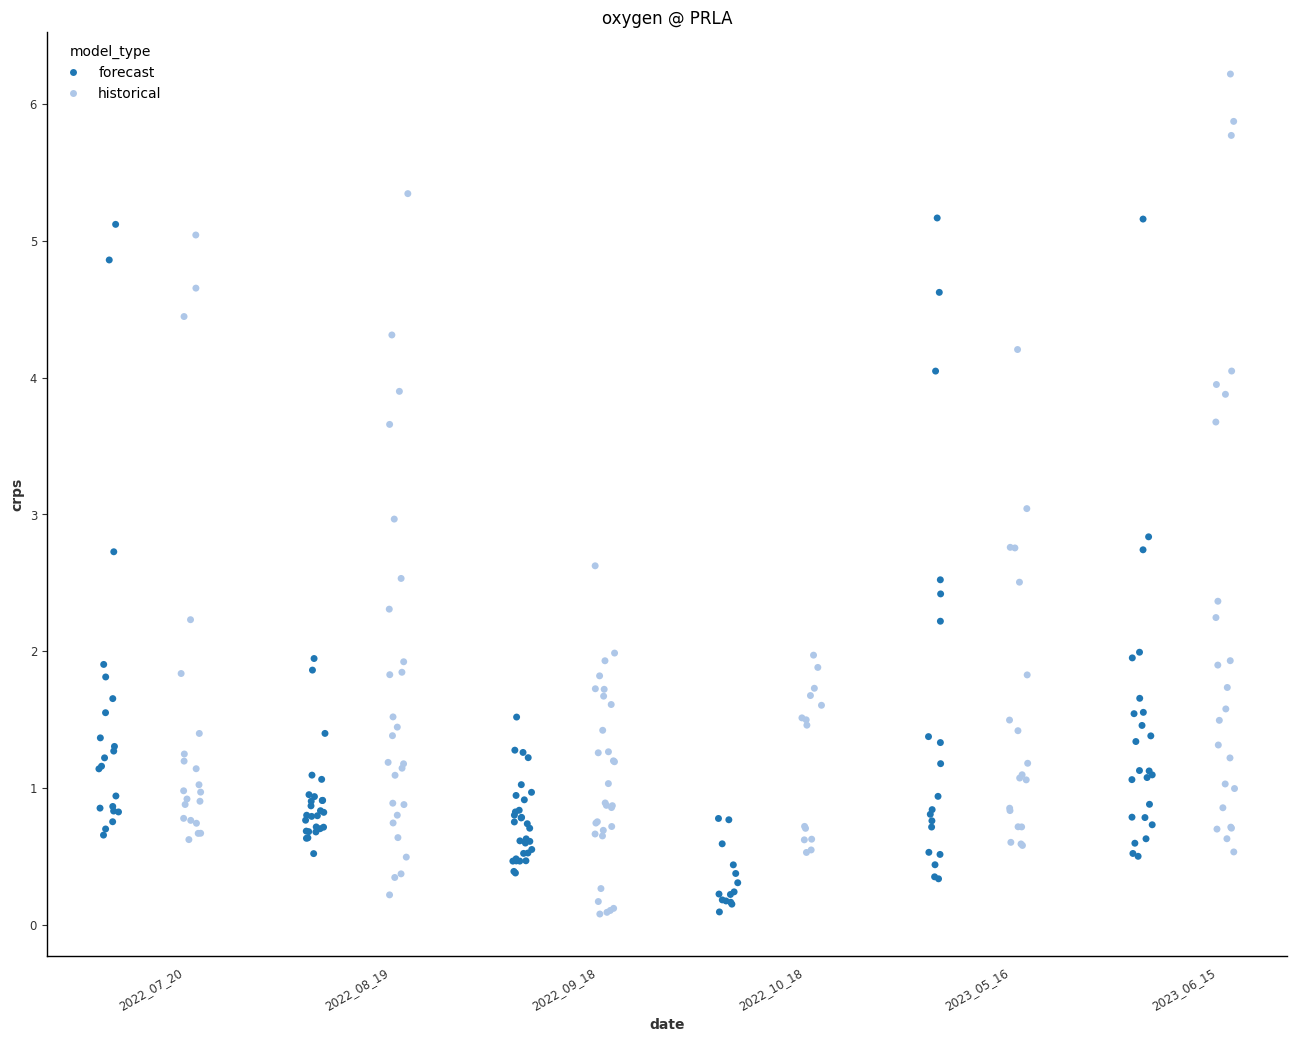

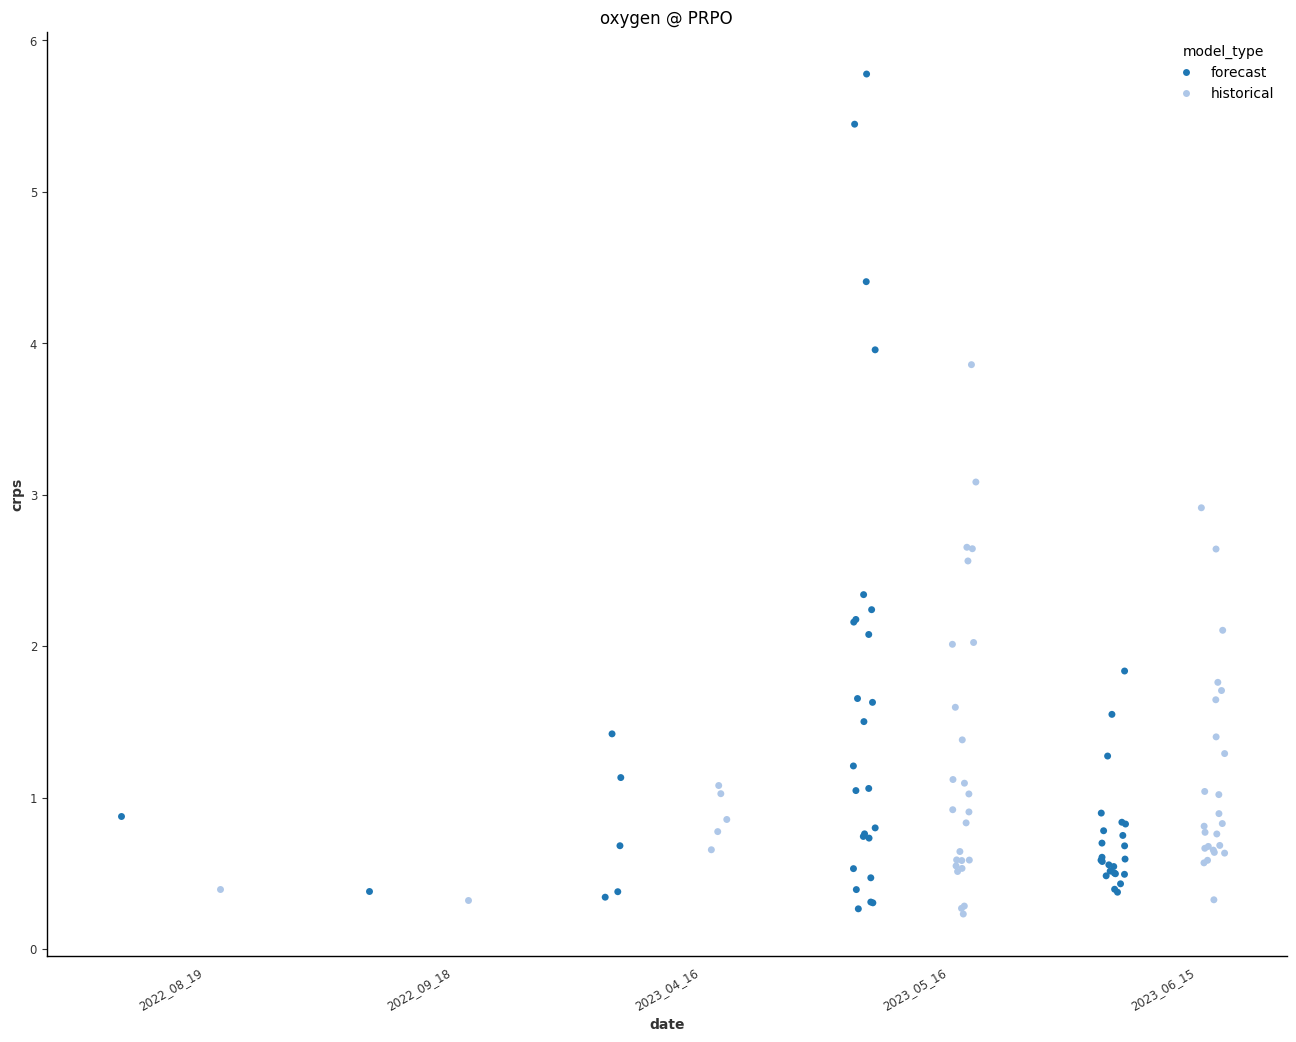

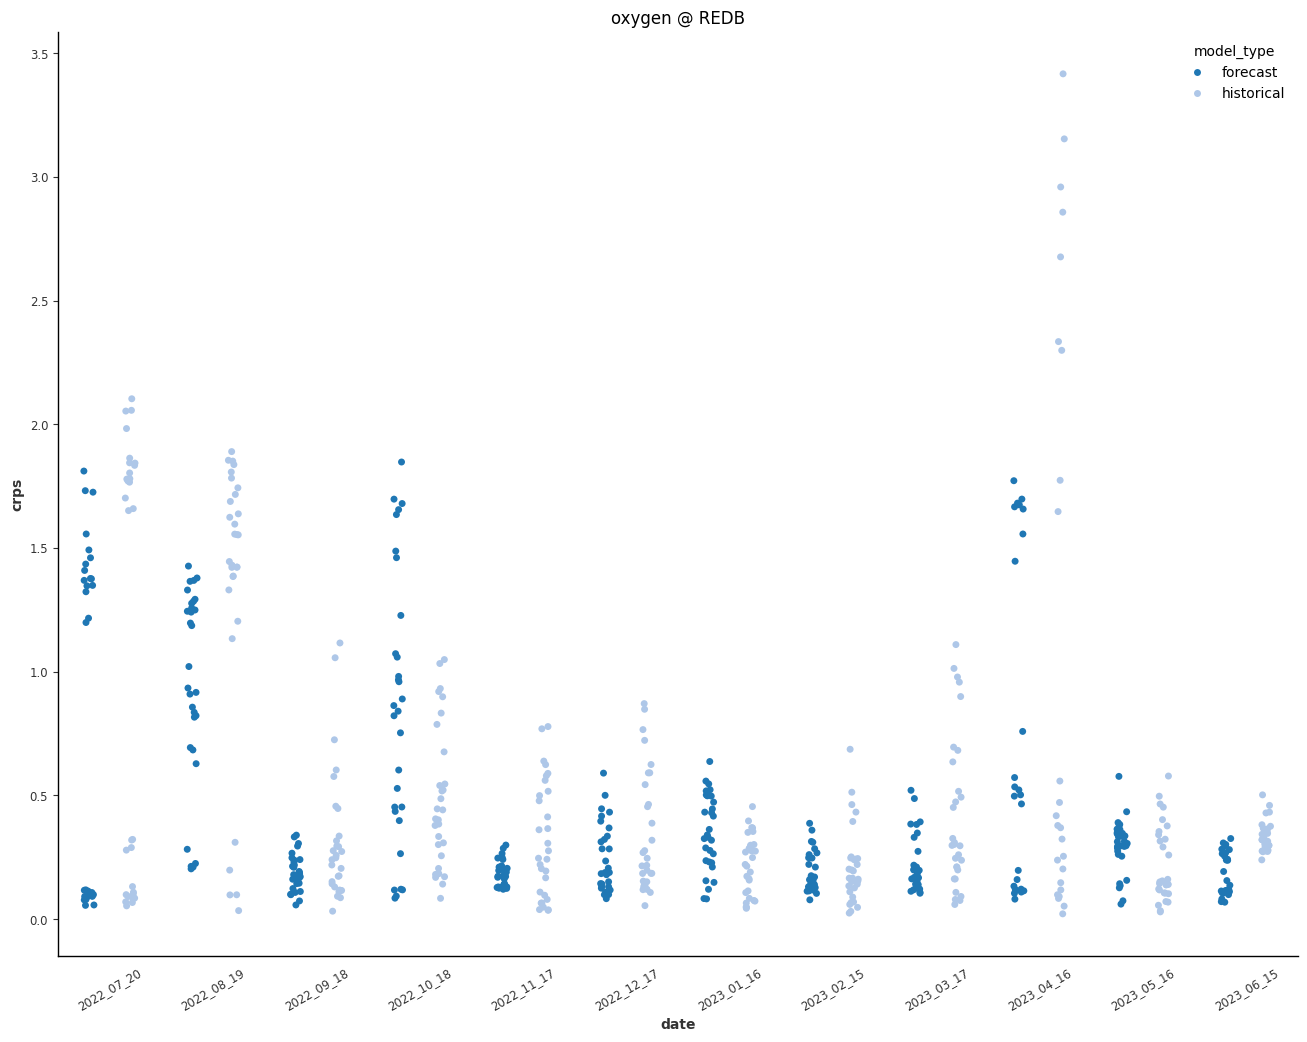

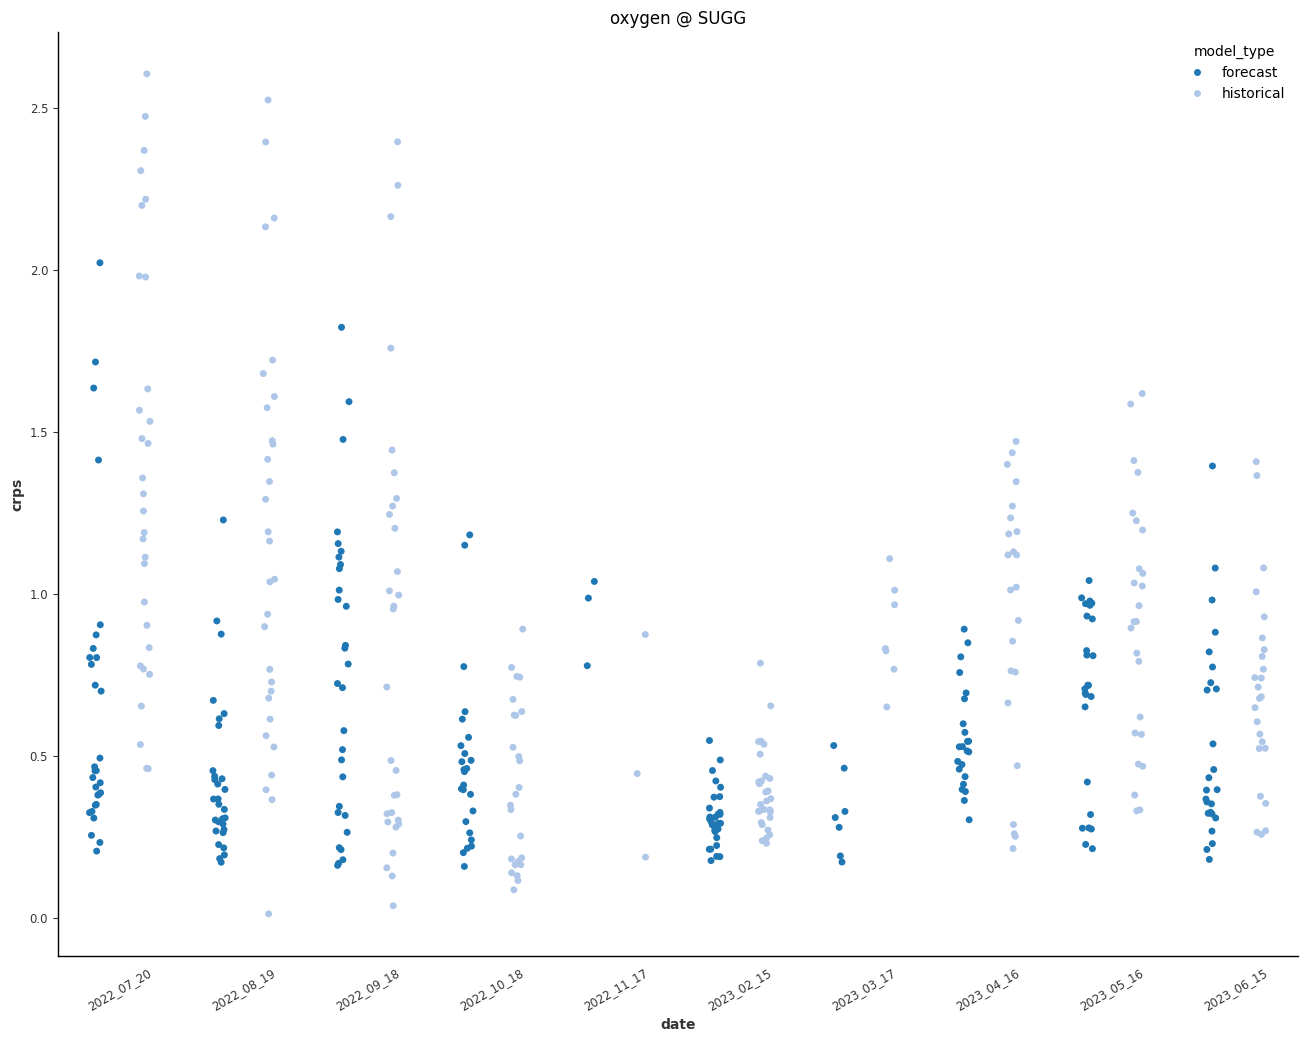

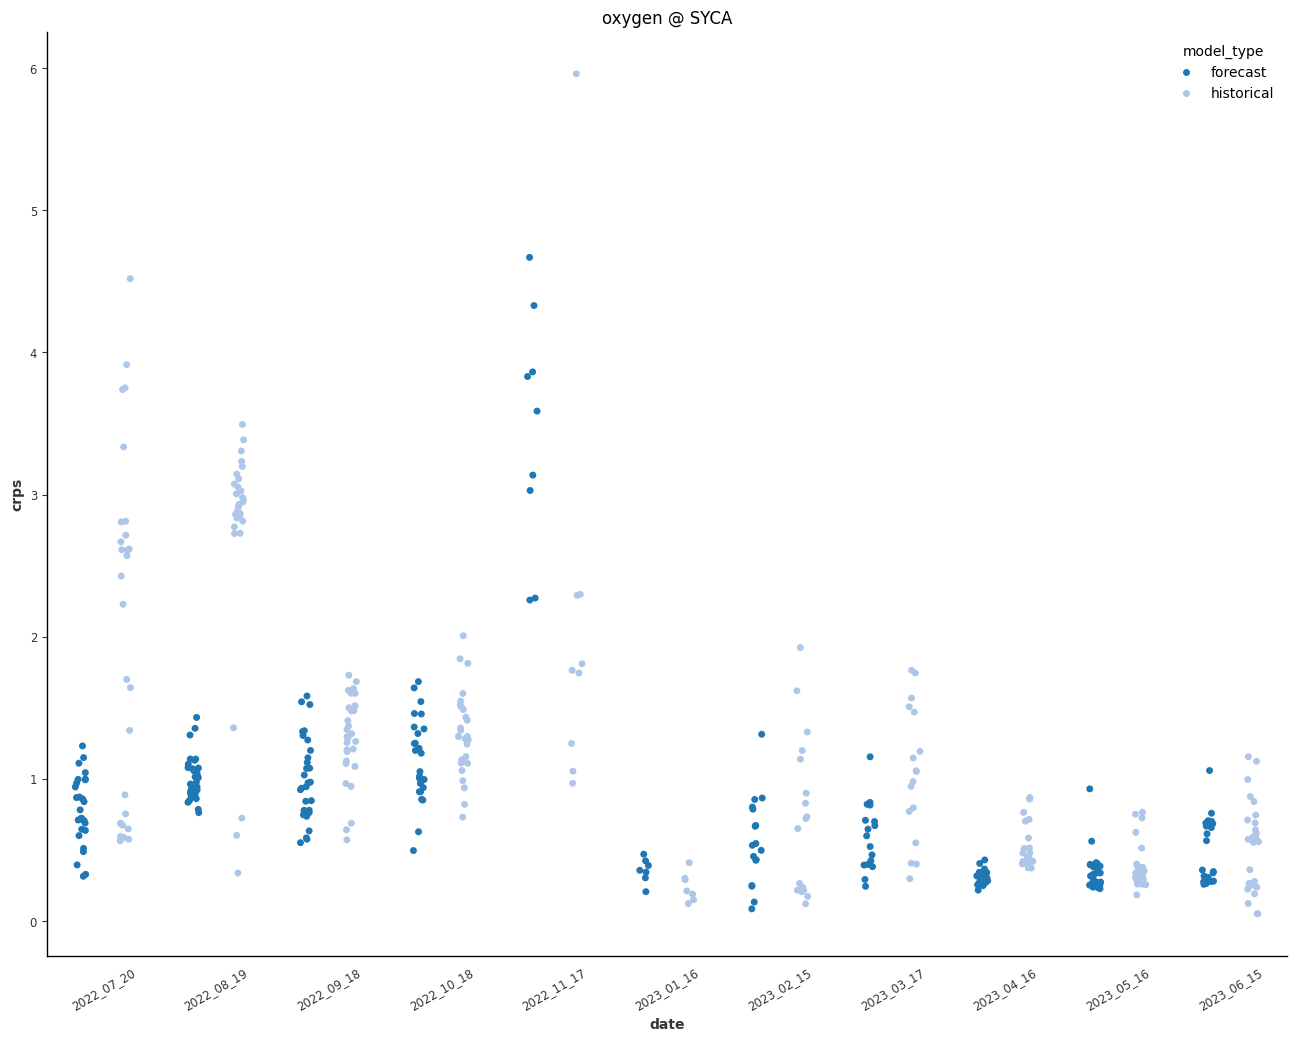

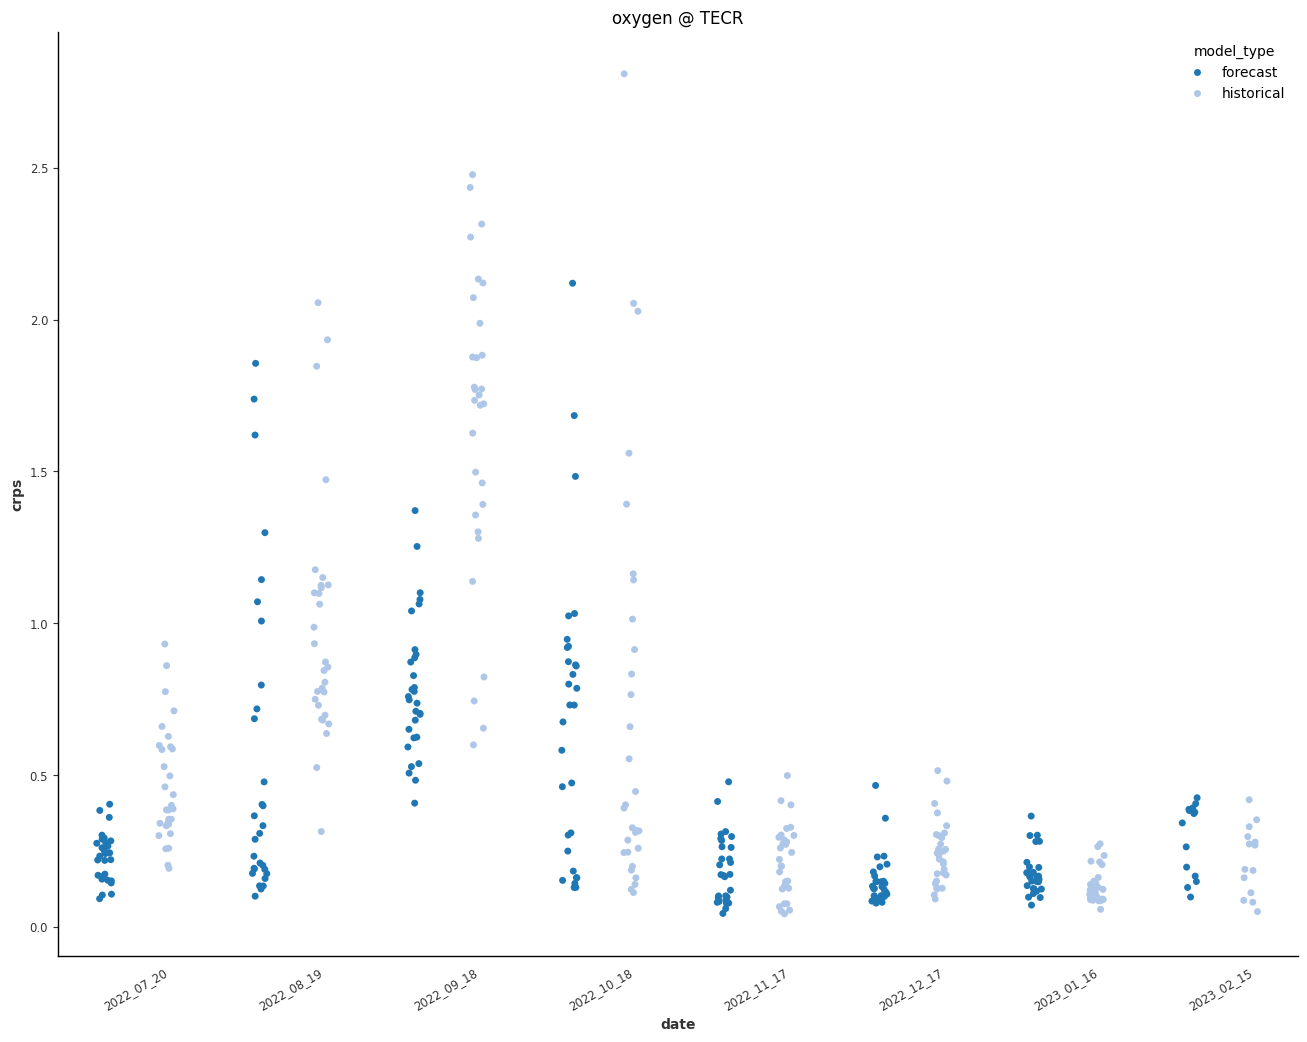

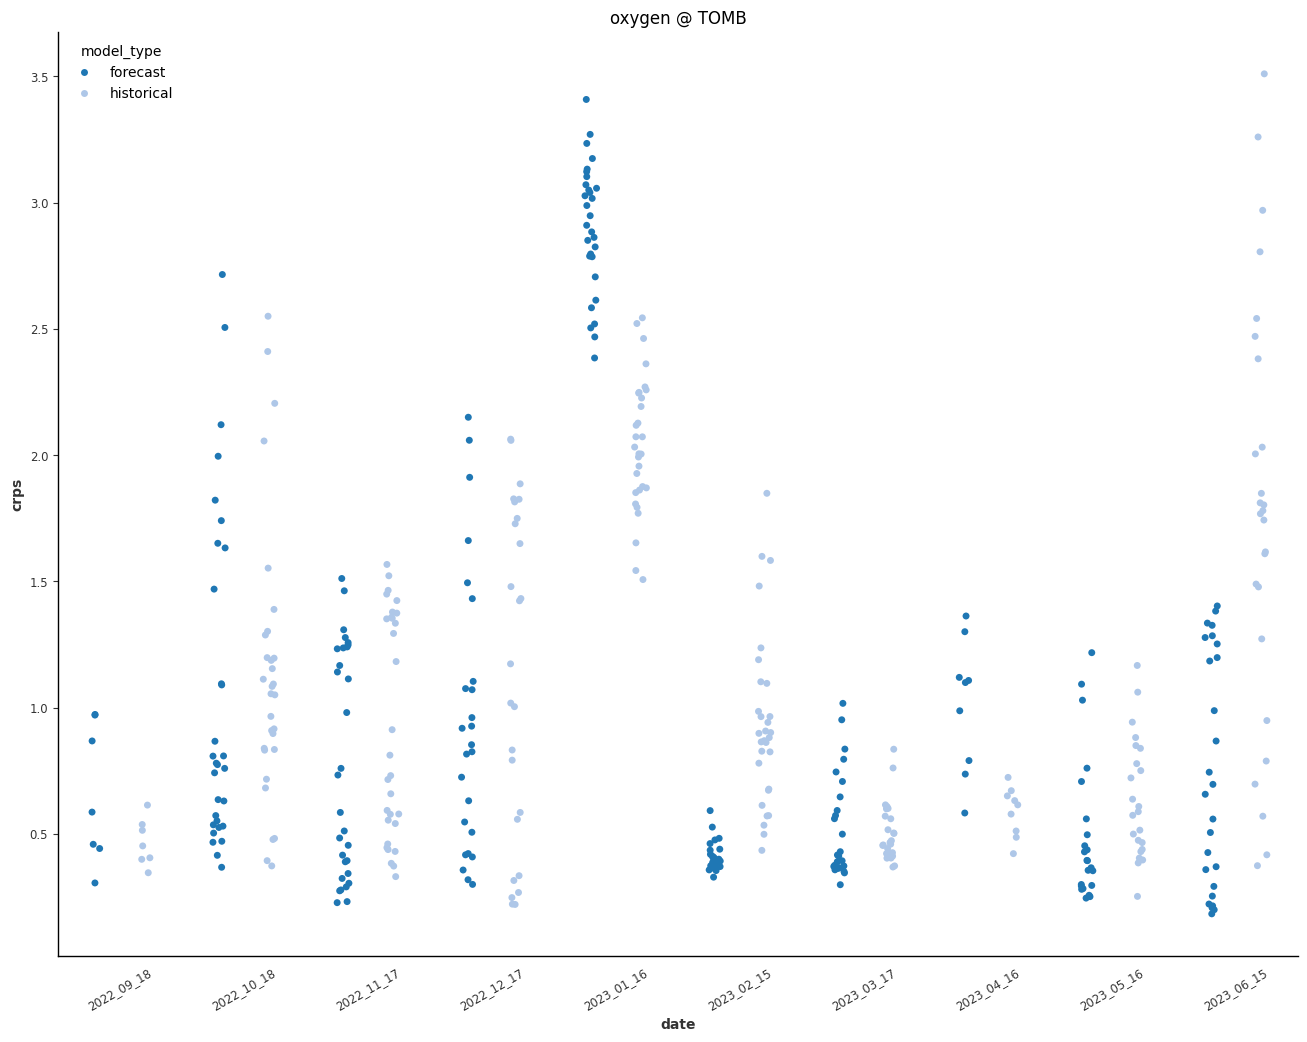

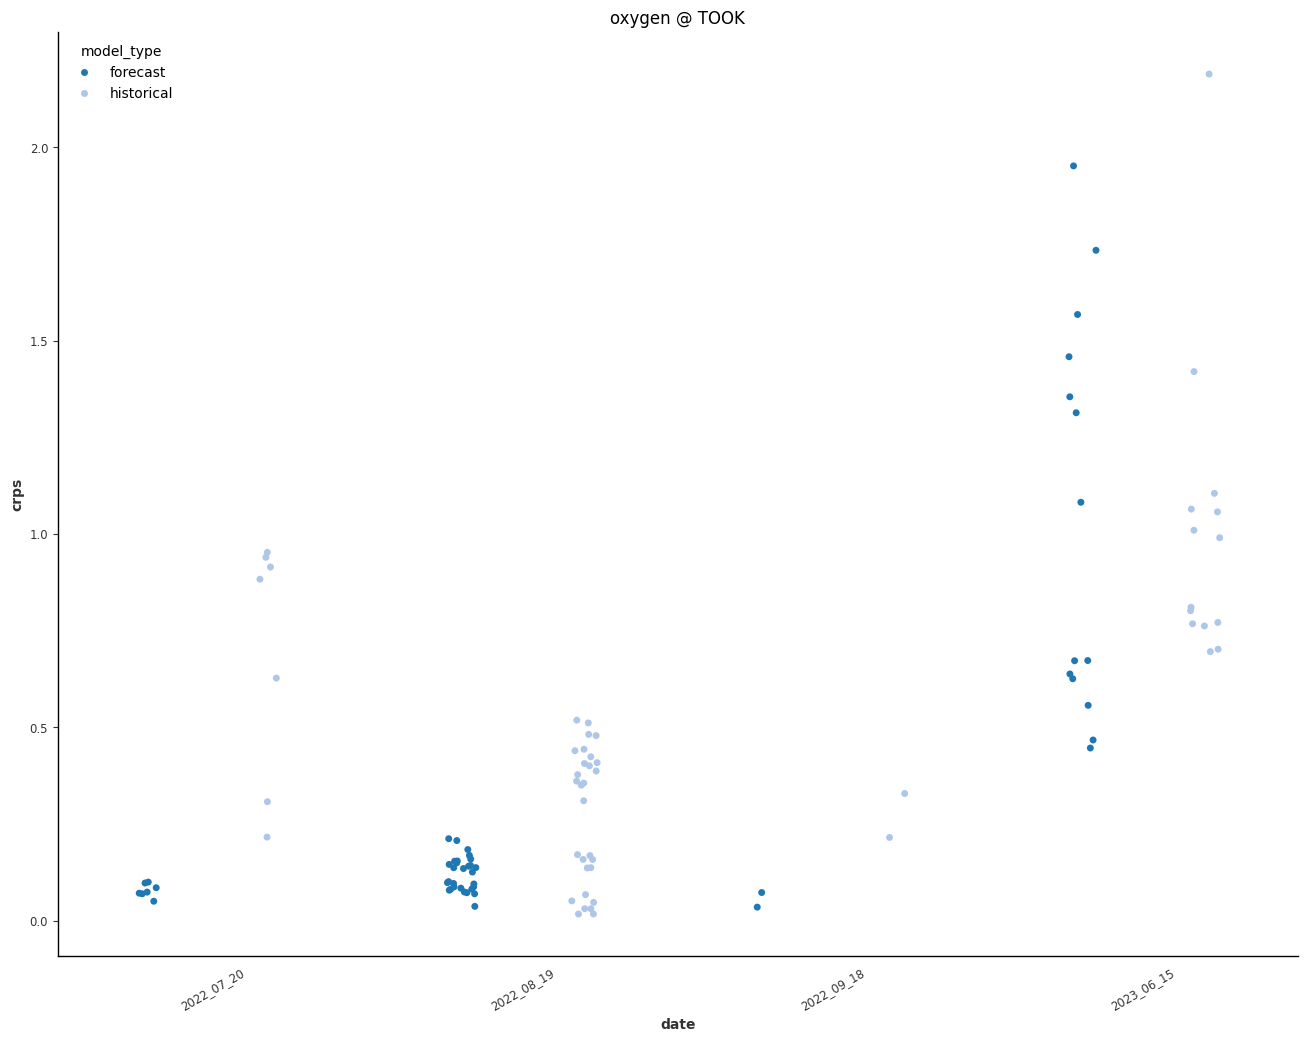

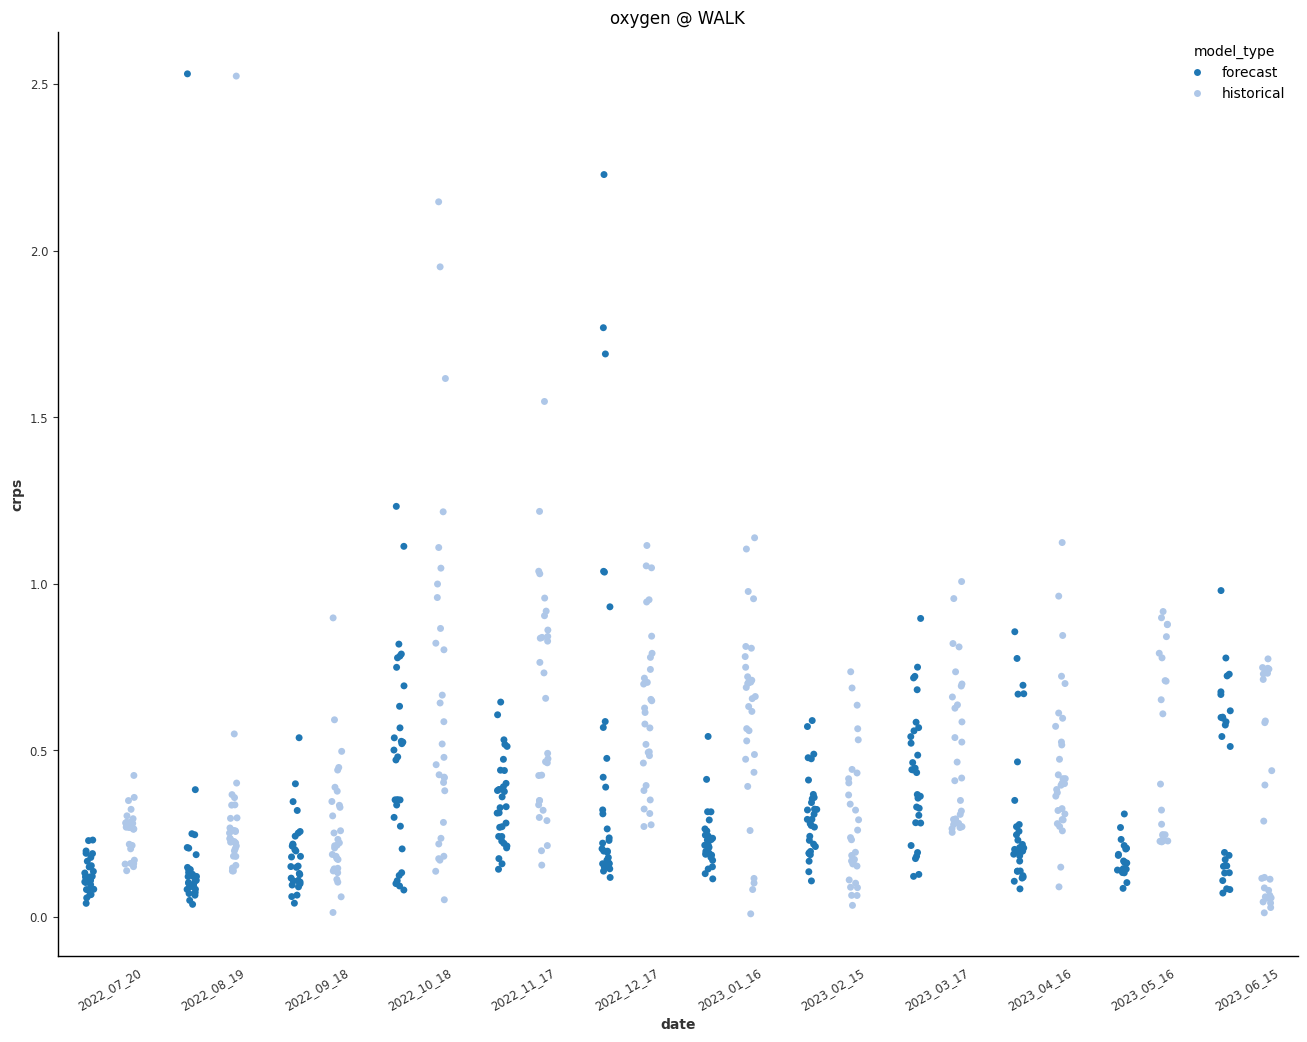

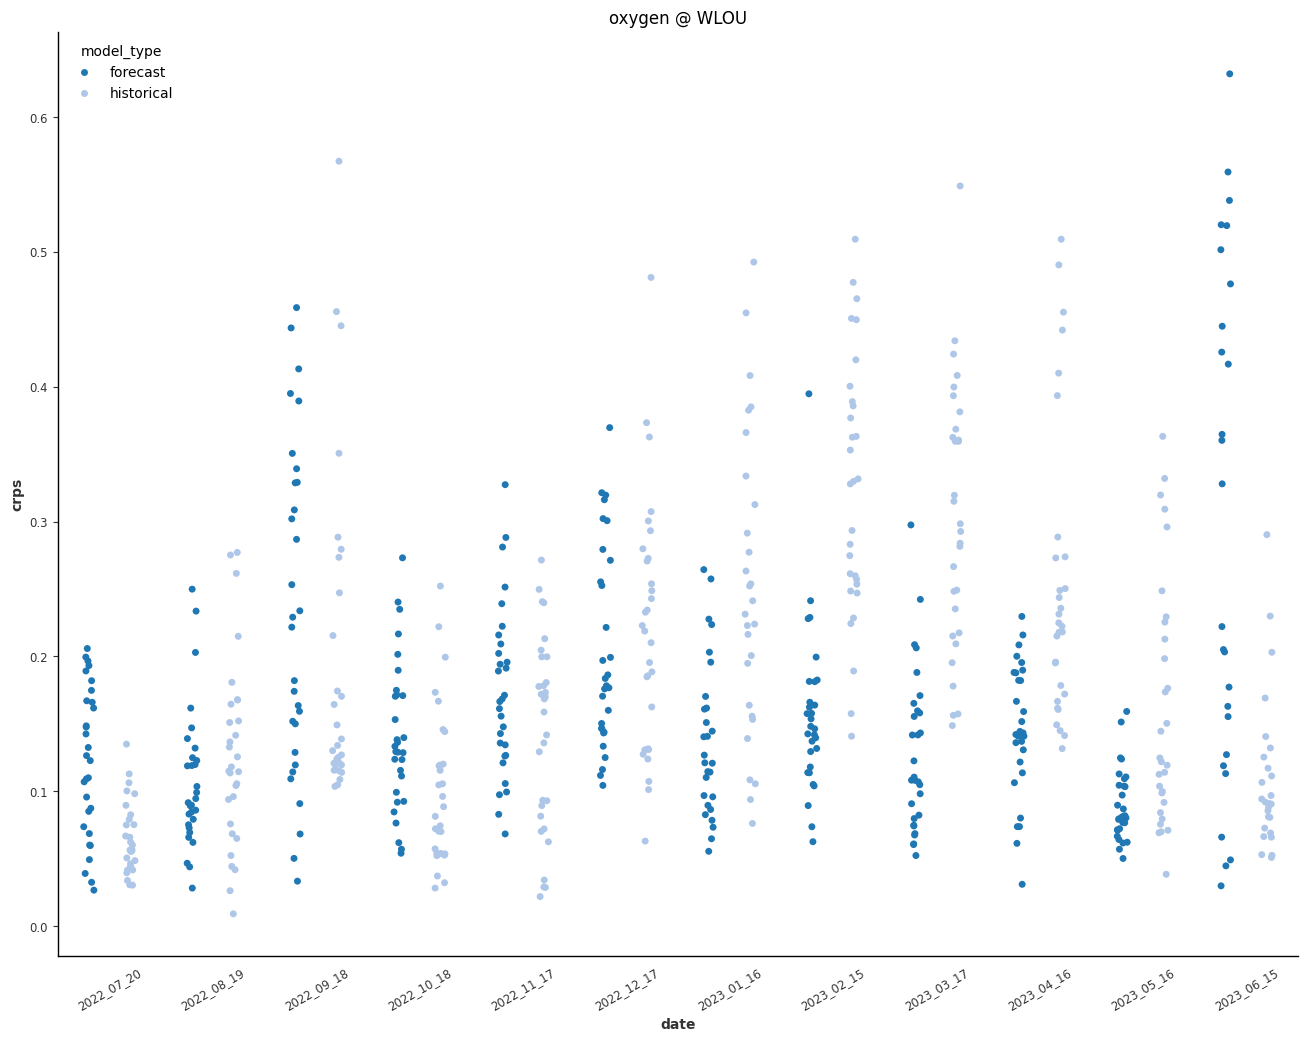

In [49]:
for site in targets.site_id.unique():
    plot_crps_bydate(f'forecasts/{site}/oxygen/BlockRNN_default/forecast*', targets, site, 'oxygen')

Make a plot that has site on the x axis and y-axis the number of times the percent improvement in crps AND rmse is positive

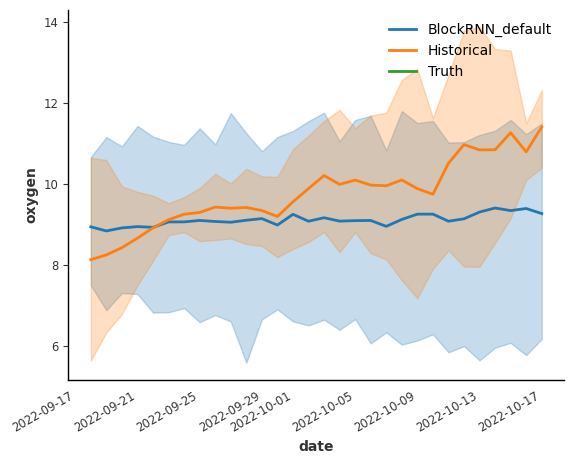

In [51]:
site_id = 'PRPO'
target_variable = 'oxygen'
date = '2022_09_18'
plot_forecast(date, targets, site_id, target_variable, 'BlockRNN_default')

In [27]:
['2022_07_20', '2022_08_19', '2022_09_18', '2022_10_18', '2022_11_17', '2022_12_17', '2023_01_16', '2023_02_15', '2023_03_17', '2023_04_16', '2023_05_16', '2023_06_15']

['2022_07_20',
 '2022_08_19',
 '2022_09_18',
 '2022_10_18',
 '2022_11_17',
 '2022_12_17',
 '2023_01_16',
 '2023_02_15',
 '2023_03_17',
 '2023_04_16',
 '2023_05_16',
 '2023_06_15']

## Still issues with december and february times that you need to figure out

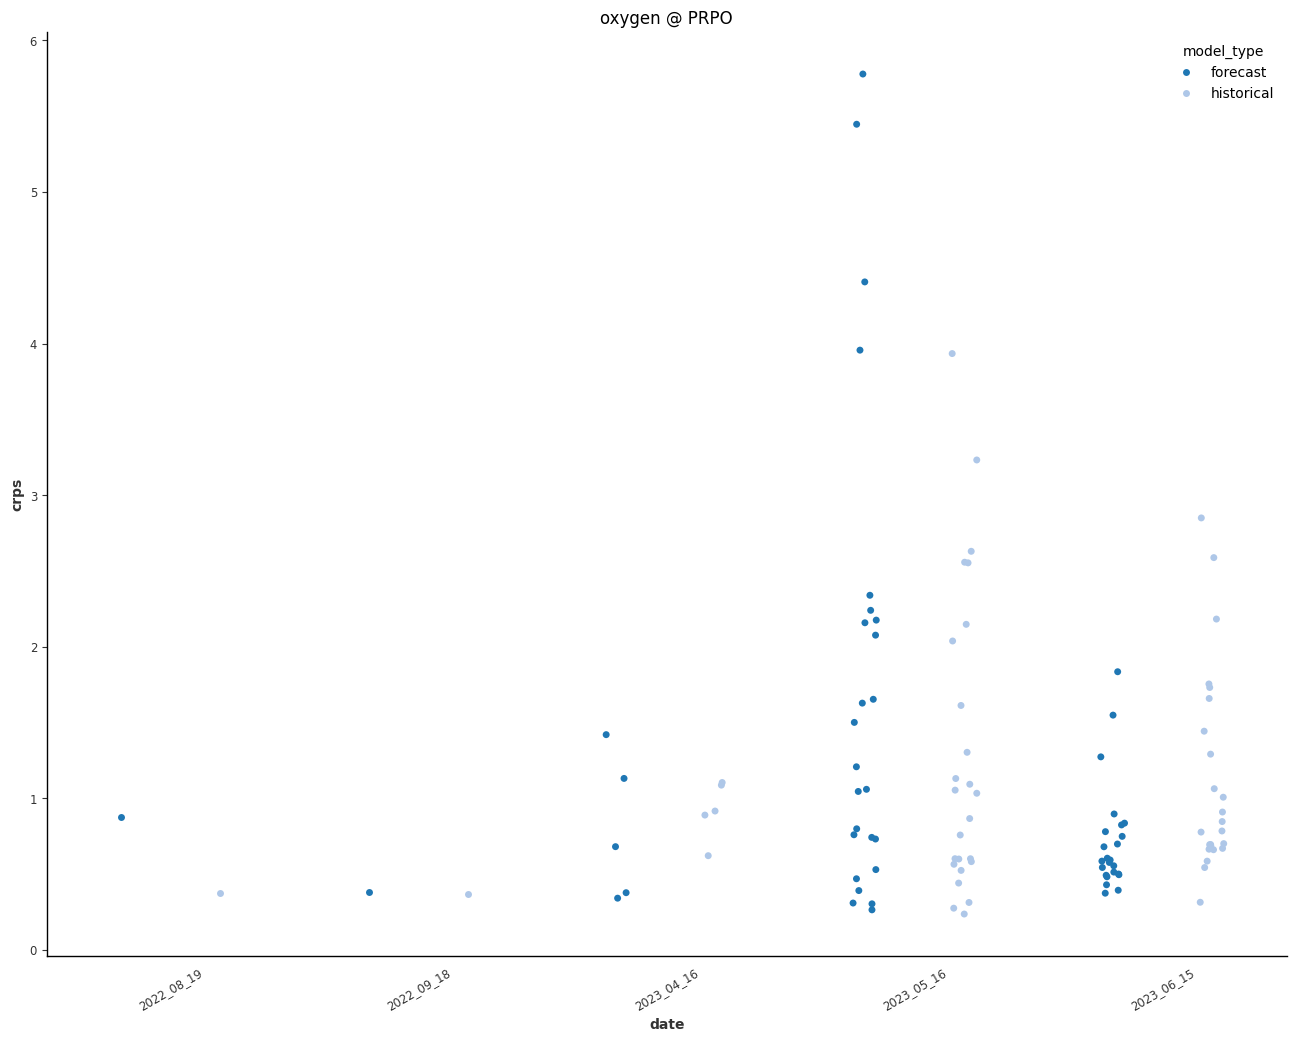

In [65]:
site_id = 'PRPO'
target_variable = 'oxygen'
plot_crps_bydate(f'forecasts/{site_id}/{target_variable}/BlockRNN_default/forecast*', targets, site_id, target_variable)

In [17]:
import glob
def plot_crps_bydate(glob_prefix, targets_df, site_id, target_variable, suffix="", plot_name=None):

    plt.figure(figsize=(16, 12))
    score_dict = {}
    
    csv_list = sorted(glob.glob(glob_prefix))
    
    for csv in csv_list:
        score_dict = modify_score_dict(
            csv, 
            targets_df, 
            target_variable, 
            site_id, 
            suffix, 
            score_dict
        )

    score_df = pd.DataFrame([(site_id, data_dict['crps_forecast'][i], data_dict['crps_historical'][i]) \
                                 for site_id, data_dict in score_dict.items() \
                                 for i in range(len(data_dict['crps_forecast']))],
                            columns=["date", 'forecast', 'historical'])
    score_df = pd.melt(score_df, id_vars=["date"], var_name="model_type", value_name="crps")

    # Now creating the plot
    p = sns.stripplot(score_df, x="date", y="crps", hue="model_type", dodge=True, palette="tab20")

    # plot the mean line
    sns.boxplot(
        showmeans=False,
        meanline=False,
        meanprops={'color': 'k', 'ls': '-', 'lw': 2},
        medianprops={'visible': True, 'lw':1.75},
        whiskerprops={'visible': False},
        zorder=10,
        data=score_dict,
        showfliers=False,
        showbox=False,
        showcaps=False,
        ax=p,
    )
    plt.grid(False)
    plt.ylabel("crps")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    plt.title(f'{target_variable} @ {site_id}')
    
    # Saving the plot if desired
    if plot_name != None:
        if not os.path.exists(f"plots/{site_id}/{target_variable}/"):
            os.makedirs(f"plots/{site_id}/{target_variable}/")
        plt.savefig(f"plots/{site_id}/{target_variable}/{plot_name}")

In [63]:
def modify_score_dict(csv, targets_df, target_variable, site_id, suffix, score_dict, score_rmse=False):
    try:
        forecast_df = pd.read_csv(csv)
    except:
        return score_dict
    forecast_df["datetime"] = pd.to_datetime(forecast_df["datetime"])
    times = pd.DatetimeIndex(forecast_df["datetime"])
    forecast_df = forecast_df.set_index("datetime")

    # Getting the validation set from targets
    forecast_horizon = len(forecast_df)
    validation_series = get_validation_series(
        targets_df, 
        site_id, 
        target_variable, 
        times[0], 
        forecast_horizon,
    )

    # If there is no validation set at the site skip
    if len(validation_series) == 0:
        return score_dict

    try:
        filtered_model_forecast, filtered_validation_series = filter_forecast_df(
            forecast_df, 
            validation_series
        )
    except:
        return score_dict

    # Initialize in case site id is empty at the site
    time_str = times[0].strftime('%Y_%m_%d')
    if time_str not in score_dict:
        score_dict[time_str] = {}
        
    # Computing CRPS and recording
    filtered_validation_ts = TimeSeries.from_times_and_values(
        filtered_validation_series.index, 
        filtered_validation_series.values, 
        fill_missing_dates=True,
        freq='D'
    )
    if score_rmse:
        rmse_score = rmse(filtered_validation_ts, filtered_model_forecast)
        score_dict[time_str]["rmse_forecast"] = rmse_score
    else:
        crps_scores = crps(
            filtered_model_forecast, 
            filtered_validation_ts,
            observed_is_ts=True,
        )
        score_dict[time_str]["crps_forecast"] = crps_scores.pd_dataframe().values[:, 0]
        
    # Now, making the forecast based off of historical mean and std
    historical_model = HistoricalForecaster(
        targets=targets_df,
        site_id=site_id,
        target_variable=target_variable,
        output_csv_name=None,
        validation_split_date=str(times[0])[:10],
        forecast_horizon=forecast_horizon,
    )
    # Computing CRPS of historical forecast and plotting
    # If issue making historical forecasts, then we'll skip.
    try:
        historical_model.make_forecasts()
    except:
        del score_dict[time_str]
        return score_dict
    historical_forecast_df = historical_model.forecast_ts.pd_dataframe(
        suppress_warnings=True
    )
    
    filtered_historical_forecast, filtered_validation_series = filter_forecast_df(
        historical_forecast_df, 
        validation_series
    )

    if score_rmse:
        rmse_score = rmse(filtered_validation_ts, filtered_historical_forecast)
        score_dict[time_str]["rmse_historical"] = rmse_score
    else:
        crps_scores = crps(
            filtered_historical_forecast, 
            filtered_validation_ts,
            observed_is_ts=True,
        )
        score_dict[time_str]["crps_historical"] = crps_scores.pd_dataframe().values[:, 0]
    return score_dict

In [64]:
def filter_forecast_df(forecast_df, validation_series):
    """
    Assumes validation series is a TimeSeries
    and forecast_df has an datetime index
    """
    gaps = validation_series.gaps()
    # Filtering forecast df to only include dates in the validation series
    if len(gaps) > 0:
        for i in range(len(gaps)):
            gap_start = gaps.iloc[i].gap_start
            gap_end = gaps.iloc[i].gap_end
            forecast_df = forecast_df[(forecast_df.index < gap_start) \
                                      | (forecast_df.index > gap_end)]

    times = forecast_df.index
    validation_series = validation_series.pd_series().dropna()
    # Checking that the dates indices are the same, i.e. that filtering worked properly
    assert (validation_series.index == forecast_df.index).all()

    values = forecast_df.loc[:, forecast_df.columns!="datetime"].to_numpy().reshape(
        (len(times), 1, -1)
    )

    # Issue is occurring here, why oh why TimeSeries so annoying
    filtered_forecast_ts = TimeSeries.from_times_and_values(
        times, 
        values,
        fill_missing_dates=True,
        freq='D'
    )

    return filtered_forecast_ts, validation_series

In [55]:
gpd.to_datetime('2022-09-18')

Timestamp('2022-09-18 00:00:00')

In [21]:
def get_validation_series(targets_df, site_id, target_variable, date, forecast_horizon):
    # Being careful here with the date, note that I am matching the forecast,
    # so I don't need to advance.
    date_range = pd.date_range(
        date, 
        periods=forecast_horizon, 
        freq='D',
    )
    # Filter targets df for site and variable
    site_df = targets_df[targets_df["site_id"] == site_id]
    site_var_df_ = site_df[["datetime", target_variable]]
    site_var_df = site_var_df_.copy()
    site_var_df["datetime"] = pd.to_datetime(site_var_df_["datetime"])
    validation_df = pd.DataFrame()
    # Now creating a new dataframe of observed series from the forecast
    # window
    for date in date_range:
        entry = site_var_df[site_var_df.datetime == date]
        if len(entry) == 0:
            entry = pd.DataFrame({'datetime': [date], f'{target_variable}': [np.nan]})
        validation_df = pd.concat(
            [validation_df, entry], 
            axis=0
        ).reset_index(drop=True)

    times = pd.to_datetime(validation_df.datetime)
    times = pd.DatetimeIndex(times)
    validation_series = TimeSeries.from_times_and_values(
        times,
        validation_df[[target_variable]],
        fill_missing_dates=True,
        freq="D",
    )
    
    return validation_series